In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [51]:
def transition_probability(curr_state, next_state, action):
    action_value = [-1, -10, 1, 10] # curr_state - next_state (based on state space)
    col = int(curr_state/10)
    row = int(curr_state%10)
    unallowed = [] # unallowed directions for a given state
    if row==0:
        unallowed.append(0) # top
    elif row==9:
        unallowed.append(2) # bottom
    if col==0:
        unallowed.append(1) # left
    elif col==9:
        unallowed.append(3) # right
    
    value = action_value[action]
    neighborhood = []
    for index in np.arange(0,4): # building neighborhood of the current state
        if index not in unallowed:
            neighborhood.append(curr_state + action_value[index])
    if unallowed: # not empty => edges or corners
        if len(unallowed)==2: # corners
            if action in unallowed: # action to move off the grid
                if next_state==curr_state: # => same_state
                    return 1-w+w/4+w/4
                elif next_state in neighborhood: # neighboring valid states
                    return w/4
            else: # action to stay in the grid
                if next_state==curr_state: # => same_state
                    return w/4+w/4
                elif next_state==curr_state+value and next_state in neighborhood: # intended state
                    return 1-w+w/4
                elif next_state in neighborhood: # neighboring valid states
                    return w/4      
        else: # edges
            if action in unallowed: # action to move off the grid
                if next_state==curr_state: # => same_state
                    return 1-w+w/4
                elif next_state in neighborhood: # neighboring valid states
                    return w/4
            else: # action to stay in the grid
                if next_state==curr_state: # => same_state
                    return w/4
                elif next_state==curr_state+value and next_state in neighborhood: # intended state
                    return 1-w+w/4
                elif next_state in neighborhood: # neighboring valid states
                    return w/4
            
    else: # non boundary
        if next_state==curr_state + value and next_state in neighborhood:
            return 1-w+w/4
        elif next_state in neighborhood:
            return w/4
    return 0

def construct_neighborhood(curr_state):
    col = int(curr_state/10)
    row = int(curr_state%10)
    action_value = [-1, -10, 1, 10] # curr_state - next_state (based on state space)
    unallowed = [] # unallowed directions for a given state
    if row==0:
        unallowed.append(0) # top
    elif row==9:
        unallowed.append(2) # bottom
    if col==0:
        unallowed.append(1) # left
    elif col==9:
        unallowed.append(3) # right
    
    neighborhood = []
    for index in np.arange(0,4): # building neighborhood of the current state
        if index not in unallowed:
            neighborhood.append(curr_state + action_value[index])
    return neighborhood

def value_iteration_action(reward, state_space, action_set, discount_factor):
    epsilon = 0.01
    V = np.zeros(shape=[10,10])
    pi = np.zeros(shape=[10,10])
    delta = float("inf")
    flatten_state = []
    for element in state_space:
        for el in element:
            flatten_state.append(el)
            
    maximum = -1*float("inf")
    while delta > epsilon:
        delta = 0 
        for curr_state in flatten_state:
            curr_col = int(curr_state/10)
            curr_row = int(curr_state%10)
            v = V[curr_row][curr_col]
            neighborhood = construct_neighborhood(curr_state)
            states_to_visit = neighborhood + [curr_state]
            maximum = -1*float("inf")
            for action in action_set:
                total = 0
                for next_state in states_to_visit:
                    p = transition_probability(curr_state, next_state, action)
                    next_col = int(next_state/10)
                    next_row = int(next_state%10)
                    total += p * (reward[next_row, next_col] + discount_factor * V[next_row][next_col])
                if total>maximum:
                    maximum = total
            V[curr_row][curr_col] = maximum
            delta = max(delta, np.abs(v - V[curr_row][curr_col]))
    
    maximum = -1*float("inf")
    for curr_state in flatten_state:
        curr_col = int(curr_state/10)
        curr_row = int(curr_state%10)
        neighborhood = construct_neighborhood(curr_state)
        states_to_visit = neighborhood + [curr_state]
        maximum = -1*float("inf")
        for action in [0,1,3,2]: # or action set
            total = 0
            for next_state in states_to_visit:
                p = transition_probability(curr_state, next_state, action)
                next_col = int(next_state/10)
                next_row = int(next_state%10)
                total += p * ((reward[next_row, next_col]) + discount_factor * V[next_row][next_col])
            if total>maximum:
                maximum = total
                max_index = action
        pi[curr_row][curr_col] = max_index
    return pi

In [52]:
num_states=100
num_actions=4
state_space = np.zeros(shape=[10,10])
state_space = [[10.0*i+j for i in range(0,10)] for j in range(0, 10)]
action_set = [0, 1, 2, 3] # top, left, bottom, right
discount_factor = 0.8
w=0.1


In [53]:
prob_matrix = np.zeros(shape=[100,100,4])
#prob_matrix=[[[transition_probability(i,j,k) for i in range(0,100)] for j in range(0, 100)] for k in range(0,4)] 
for k in range(0,4):
    for j in range(0,100):
        for i in range(0,100):
            prob_matrix[i][j][k]=transition_probability(i,j,k);


np.shape(prob_matrix)

(100, 100, 4)

In [54]:
from cvxopt import matrix, solvers

def irl(num_states, num_actions, prob_matrix, opt_policy, discount_factor, Rmax, reg):
    
    c = np.zeros(3 * num_states)
    c[num_states:2 * num_states] = -1
    c[2 * num_states:3 * num_states ] = reg
    
    h = np.zeros(2 * num_states * (num_actions - 1) + 4 * num_states)
    h[2 * num_states * (num_actions - 1) + 2 * num_states:2 * num_states * (num_actions - 1) + 4 * num_states ]=Rmax
    
    G = np.zeros([2 * num_states * (num_actions - 1) + 4 * num_states, 3 * num_states])
    
    for i in range(num_states):
        G[2 * num_states * (num_actions - 1) + 2 * num_states+i,i ]=1 #800-900
        G[2 * num_states * (num_actions - 1) + 3 * num_states+i,i ]=-1 #900-1000
        G[2 * num_states * (num_actions - 1) + i , i ]=1 #600-700, 1st col
        G[2 * num_states * (num_actions - 1) + i , 2 * num_states+i ]=-1 #600-700, 3rd col
        G[2 * num_states * (num_actions - 1) + num_states+i,i ]=-1 #700-800, 1st col
        G[2 * num_states * (num_actions - 1) +num_states+ i,2 * num_states+i ]=-1 #700-800, 3rd col
    
#     for i in range(num_states):            ##2nd column for first 300 rows
#         G[i, num_states + i] = 1
#         G[num_states+i,num_states + i]=1
#         G[2*num_states+i,num_states + i]=1
    
    for i in range(num_states):         ##first column for first 600 rows
        a_i = int(opt_policy[i%10][i/10])
        second_term = np.linalg.inv(np.identity(num_states) - discount_factor * prob_matrix[:,:,a_i])

        count = 0
        for a in range(num_actions):
            if (a != a_i):
                G[i * (num_actions - 1) + count, :num_states] = - np.dot(np.asarray(prob_matrix[i,:,a_i]) - np.asarray(prob_matrix[i,:,a]), second_term)
            
                G[num_states * (num_actions - 1) + i * (num_actions - 1) + count, :num_states] = - \
                np.dot(np.asarray(prob_matrix[i,:,a_i]) - np.asarray(prob_matrix[i,:,a]), second_term)
                
                G[i * (num_actions - 1) + count, num_states + i] = 1
                #G[num_states * (num_actions - 1) + i * (num_actions - 1) + count,num_states + i] = 1
                count += 1
            
    sol = solvers.lp(matrix(c), matrix(G), matrix(h))
    return sol

In [55]:
import matplotlib.pyplot as plt
x_plot=[]
reward_1 = np.zeros(shape=[10,10])
reward_1[9][9] = 1
actual_policy=value_iteration_action(reward_1, state_space, action_set, discount_factor)
opt_policy=actual_policy
Rmax=1

In [56]:
max_acc=0
max_reg=0
max_reward=[]
for i in range(0,500):
    x=irl(num_states, num_actions, prob_matrix, opt_policy, discount_factor, Rmax, i/100.0)
    reward_computed=x['x'][:num_states]
    reward_computed=np.reshape(reward_computed,(10,10))
    reward_computed=np.transpose(reward_computed)
    policy_computed = value_iteration_action(reward_computed, state_space, action_set, discount_factor)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    acc=count/100.0;
    if(acc>max_acc):
        max_acc=acc
        max_reg=i/100.0
        max_reward=reward_computed
    x_plot.append(acc);



     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.1686e+01 -1.0212e+02  4e+02  7e-01  5e+00  1e+00
 2: -2.0092e+01 -8.0064e+01  3e+02  5e-01  3e+00  8e-01
 3: -3.0098e+01 -5.8419e+01  1e+02  2e-01  2e+00  4e-01
 4: -3.4817e+01 -4.9165e+01  6e+01  1e-01  8e-01  2e-01
 5: -3.7168e+01 -4.5524e+01  4e+01  7e-02  5e-01  9e-02
 6: -3.8941e+01 -4.2762e+01  2e+01  3e-02  2e-01  4e-02
 7: -4.0382e+01 -4.1586e+01  5e+00  1e-02  7e-02  6e-03
 8: -4.1014e+01 -4.1546e+01  2e+00  4e-03  3e-02  3e-03
 9: -4.1048e+01 -4.1541e+01  2e+00  4e-03  3e-02  2e-03
10: -4.1291e+01 -4.1535e+01  1e+00  2e-03  1e-02  1e-03
11: -4.1350e+01 -4.1515e+01  7e-01  1e-03  9e-03  8e-04
12: -4.1419e+01 -4.1496e+01  3e-01  6e-04  4e-03  3e-04
13: -4.1473e+01 -4.1491e+01  8e-02  1e-04  1e-03  8e-05
14: -4.1479e+01 -4.1487e+01  3e-02  6e-05  4e-04  3e-05
15: -4.1480e+01 -4.1486e+01  3e-02  5e-05  3e-04  3e-05
16: -4.1481e+01 -4.1485e+01  2e-02  3e-05  2e-04  

26: -3.8117e+01 -3.8117e+01  2e-03  4e-06  2e-05  2e-06
27: -3.8117e+01 -3.8117e+01  1e-03  2e-06  1e-05  1e-06
28: -3.8117e+01 -3.8117e+01  1e-04  2e-07  1e-06  1e-07
29: -3.8117e+01 -3.8117e+01  1e-05  2e-08  2e-07  1e-08
30: -3.8117e+01 -3.8117e+01  3e-06  4e-09  6e-08  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  2e+01  1e+00
 1: -9.4670e+00 -9.5830e+01  4e+02  7e-01  5e+00  1e+00
 2: -1.6870e+01 -7.4842e+01  2e+02  5e-01  3e+00  7e-01
 3: -2.5796e+01 -5.4217e+01  1e+02  2e-01  2e+00  4e-01
 4: -3.0395e+01 -4.4606e+01  6e+01  1e-01  8e-01  2e-01
 5: -3.2840e+01 -4.0897e+01  3e+01  7e-02  4e-01  8e-02
 6: -3.4481e+01 -3.8859e+01  2e+01  4e-02  2e-01  4e-02
 7: -3.6488e+01 -3.7541e+01  4e+00  9e-03  6e-02  6e-03
 8: -3.6844e+01 -3.7458e+01  2e+00  5e-03  3e-02  3e-03
 9: -3.6933e+01 -3.7370e+01  2e+00  4e-03  2e-02  2e-03
10: -3.7097e+01 -3.7377e+01  1e+00  2e-03  2e-02  1e-03
11: -3.7142e+01 -3.7360e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  2e+01  1e+00
 1: -7.5782e+00 -9.0102e+01  3e+02  7e-01  5e+00  1e+00
 2: -1.4167e+01 -7.0135e+01  2e+02  5e-01  3e+00  7e-01
 3: -2.2242e+01 -5.0436e+01  1e+02  2e-01  2e+00  4e-01
 4: -2.6981e+01 -4.0251e+01  5e+01  1e-01  7e-01  1e-01
 5: -2.9570e+01 -3.6204e+01  3e+01  5e-02  4e-01  6e-02
 6: -3.1186e+01 -3.4633e+01  1e+01  3e-02  2e-01  2e-02
 7: -3.2717e+01 -3.3870e+01  4e+00  9e-03  6e-02  7e-03
 8: -3.2958e+01 -3.3727e+01  3e+00  6e-03  4e-02  4e-03
 9: -3.3263e+01 -3.3644e+01  1e+00  3e-03  2e-02  2e-03
10: -3.3372e+01 -3.3635e+01  1e+00  2e-03  1e-02  1e-03
11: -3.3465e+01 -3.3592e+01  5e-01  1e-03  7e-03  5e-04
12: -3.3538e+01 -3.3583e+01  2e-01  4e-04  2e-03  2e-04
13: -3.3545e+01 -3.3578e+01  1e-01  3e-04  2e-03  1e-04
14: -3.3545e+01 -3.3576e+01  1e-01  2e-04  2e-03  1e-04
15: -3.3546e+01 -3.3572e+01  1e-01  2e-04  1e-03  1e-04
16: -3.3547e+01 -3.3571e+01  1e-01  2e-04  1e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1: -5.6784e+00 -8.3853e+01  3e+02  6e-01  4e+00  1e+00
 2: -1.1447e+01 -6.4982e+01  2e+02  4e-01  3e+00  7e-01
 3: -1.8331e+01 -4.6710e+01  1e+02  2e-01  2e+00  4e-01
 4: -2.3278e+01 -3.5464e+01  5e+01  1e-01  7e-01  1e-01
 5: -2.4989e+01 -3.2257e+01  3e+01  6e-02  4e-01  7e-02
 6: -2.7034e+01 -3.0618e+01  1e+01  3e-02  2e-01  3e-02
 7: -2.8314e+01 -2.9549e+01  5e+00  1e-02  7e-02  8e-03
 8: -2.8713e+01 -2.9376e+01  2e+00  5e-03  4e-02  4e-03
 9: -2.8963e+01 -2.9264e+01  1e+00  2e-03  2e-02  2e-03
10: -2.9094e+01 -2.9208e+01  4e-01  9e-04  6e-03  6e-04
11: -2.9115e+01 -2.9198e+01  3e-01  7e-04  5e-03  4e-04
12: -2.9133e+01 -2.9182e+01  2e-01  4e-04  3e-03  2e-04
13: -2.9130e+01 -2.9177e+01  2e-01  4e-04  3e-03  2e-04
14: -2.9130e+01 -2.9171e+01  2e-01  3e-04  2e-03  2e-04
15: -2.9143e+01 -2.9158e+01  7e-02  1e-04  8e-04  7e-05
16: -2.9143e+01 -2.9158e+01  7e-02  1e-04  8e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1: -4.2455e+00 -7.8791e+01  3e+02  6e-01  4e+00  1e+00
 2: -9.2479e+00 -6.0490e+01  2e+02  4e-01  3e+00  7e-01
 3: -1.4925e+01 -4.3004e+01  1e+02  2e-01  2e+00  4e-01
 4: -1.9869e+01 -3.1127e+01  4e+01  9e-02  6e-01  1e-01
 5: -2.1726e+01 -2.7932e+01  2e+01  5e-02  3e-01  6e-02
 6: -2.3288e+01 -2.6226e+01  1e+01  2e-02  2e-01  3e-02
 7: -2.4283e+01 -2.5436e+01  4e+00  9e-03  6e-02  9e-03
 8: -2.4613e+01 -2.5197e+01  2e+00  5e-03  3e-02  4e-03
 9: -2.4832e+01 -2.5048e+01  8e-01  2e-03  1e-02  1e-03
10: -2.4907e+01 -2.5002e+01  4e-01  8e-04  5e-03  5e-04
11: -2.4900e+01 -2.4994e+01  4e-01  8e-04  5e-03  5e-04
12: -2.4905e+01 -2.4980e+01  3e-01  6e-04  4e-03  4e-04
13: -2.4913e+01 -2.4961e+01  2e-01  4e-04  3e-03  2e-04
14: -2.4926e+01 -2.4947e+01  9e-02  2e-04  1e-03  1e-04
15: -2.4931e+01 -2.4942e+01  4e-02  9e-05  6e-04  5e-05
16: -2.4932e+01 -2.4939e+01  3e-02  6e-05  4e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1: -2.9103e+00 -7.3383e+01  3e+02  6e-01  4e+00  1e+00
 2: -7.1064e+00 -5.5589e+01  2e+02  4e-01  3e+00  7e-01
 3: -1.1438e+01 -3.8547e+01  1e+02  2e-01  1e+00  4e-01
 4: -1.6248e+01 -2.6081e+01  4e+01  8e-02  5e-01  1e-01
 5: -1.7575e+01 -2.4122e+01  2e+01  5e-02  3e-01  7e-02
 6: -1.8979e+01 -2.1490e+01  9e+00  2e-02  1e-01  2e-02
 7: -1.9569e+01 -2.0875e+01  5e+00  1e-02  7e-02  9e-03
 8: -1.9908e+01 -2.0483e+01  2e+00  5e-03  3e-02  3e-03
 9: -1.9945e+01 -2.0443e+01  2e+00  4e-03  3e-02  3e-03
10: -2.0026e+01 -2.0370e+01  1e+00  3e-03  2e-02  2e-03
11: -2.0125e+01 -2.0303e+01  7e-01  1e-03  9e-03  8e-04
12: -2.0151e+01 -2.0264e+01  4e-01  9e-04  6e-03  5e-04
13: -2.0182e+01 -2.0246e+01  3e-01  5e-04  3e-03  3e-04
14: -2.0204e+01 -2.0230e+01  1e-01  2e-04  1e-03  1e-04
15: -2.0205e+01 -2.0228e+01  9e-02  2e-04  1e-03  9e-05
16: -2.0210e+01 -2.0220e+01  4e-02  8e-05  5e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.8502e+00 -6.8300e+01  2e+02  5e-01  3e+00  1e+00
 2: -5.3107e+00 -5.0891e+01  2e+02  4e-01  2e+00  7e-01
 3: -8.1558e+00 -3.5243e+01  1e+02  2e-01  1e+00  4e-01
 4: -1.2751e+01 -2.1945e+01  3e+01  8e-02  5e-01  1e-01
 5: -1.3880e+01 -2.0331e+01  2e+01  5e-02  3e-01  7e-02
 6: -1.4582e+01 -1.7515e+01  1e+01  2e-02  2e-01  1e-02
 7: -1.5714e+01 -1.6552e+01  3e+00  7e-03  4e-02  3e-03
 8: -1.5944e+01 -1.6318e+01  1e+00  3e-03  2e-02  1e-03
 9: -1.6103e+01 -1.6172e+01  2e-01  6e-04  4e-03  2e-04
10: -1.6122e+01 -1.6151e+01  1e-01  2e-04  1e-03  1e-04
11: -1.6134e+01 -1.6139e+01  2e-02  4e-05  2e-04  2e-05
12: -1.6136e+01 -1.6137e+01  4e-03  9e-06  6e-05  4e-06
13: -1.6136e+01 -1.6136e+01  5e-04  1e-06  7e-06  5e-07
14: -1.6136e+01 -1.6136e+01  1e-04  2e-07  2e-06  1e-07
15: -1.6136e+01 -1.6136e+01  2e-06  4e-09  2e-08  2e-09
Optimal solution found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1: -8.0769e-01 -6.2136e+01  2e+02  5e-01  3e+00  1e+00
 2: -3.4000e+00 -4.5012e+01  1e+02  3e-01  2e+00  7e-01
 3: -4.8098e+00 -3.0569e+01  9e+01  2e-01  1e+00  4e-01
 4: -8.2650e+00 -1.8578e+01  4e+01  8e-02  5e-01  1e-01
 5: -9.5808e+00 -1.5190e+01  2e+01  5e-02  3e-01  7e-02
 6: -1.0265e+01 -1.3964e+01  1e+01  3e-02  2e-01  4e-02
 7: -1.0688e+01 -1.2275e+01  5e+00  1e-02  8e-02  6e-03
 8: -1.1315e+01 -1.1701e+01  1e+00  3e-03  2e-02  1e-03
 9: -1.1435e+01 -1.1594e+01  5e-01  1e-03  8e-03  6e-04
10: -1.1498e+01 -1.1530e+01  1e-01  3e-04  2e-03  1e-04
11: -1.1508e+01 -1.1518e+01  4e-02  8e-05  5e-04  4e-05
12: -1.1512e+01 -1.1514e+01  8e-03  2e-05  1e-04  9e-06
13: -1.1512e+01 -1.1513e+01  2e-03  4e-06  3e-05  2e-06
14: -1.1513e+01 -1.1513e+01  6e-04  1e-06  8e-06  6e-07
15: -1.1513e+01 -1.1513e+01  3e-05  7e-08  4e-07  3e-08
16: -1.1513e+01 -1.1513e+01  3e-07  8e-10  5e-09  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.1340e-01 -5.9131e+01  2e+02  5e-01  3e+00  1e+00
 2: -2.0214e+00 -4.0582e+01  1e+02  3e-01  2e+00  7e-01
 3: -2.5177e+00 -2.6363e+01  8e+01  2e-01  1e+00  3e-01
 4: -5.3838e+00 -1.4274e+01  3e+01  7e-02  4e-01  1e-01
 5: -6.2022e+00 -1.0752e+01  1e+01  4e-02  2e-01  5e-02
 6: -6.7512e+00 -9.4880e+00  9e+00  2e-02  1e-01  2e-02
 7: -7.2206e+00 -8.5525e+00  4e+00  1e-02  6e-02  7e-03
 8: -7.4612e+00 -8.1000e+00  2e+00  5e-03  3e-02  2e-03
 9: -7.6752e+00 -7.8636e+00  6e-01  2e-03  9e-03  6e-04
10: -7.7149e+00 -7.8226e+00  3e-01  9e-04  5e-03  3e-04
11: -7.7471e+00 -7.7821e+00  1e-01  3e-04  2e-03  1e-04
12: -7.7582e+00 -7.7657e+00  2e-02  6e-05  4e-04  2e-05
13: -7.7605e+00 -7.7623e+00  6e-03  1e-05  9e-05  6e-06
14: -7.7611e+00 -7.7614e+00  8e-04  2e-06  1e-05  8e-07
15: -7.7612e+00 -7.7613e+00  3e-04  6e-07  4e-06  3e-07
16: -7.7612e+00 -7.7612e+00  6e-05  1e-07  8e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  4.0236e-01 -5.8923e+01  2e+02  5e-01  3e+00  1e+00
 2: -9.1729e-01 -3.6756e+01  1e+02  3e-01  2e+00  6e-01
 3: -7.9857e-01 -2.1765e+01  7e+01  2e-01  1e+00  3e-01
 4: -3.4696e+00 -8.8213e+00  2e+01  4e-02  3e-01  7e-02
 5: -3.9673e+00 -6.7796e+00  8e+00  2e-02  1e-01  3e-02
 6: -4.5034e+00 -5.3895e+00  2e+00  7e-03  4e-02  7e-03
 7: -4.5901e+00 -5.0842e+00  1e+00  4e-03  2e-02  3e-03
 8: -4.6631e+00 -4.8801e+00  6e-01  2e-03  1e-02  1e-03
 9: -4.7021e+00 -4.7663e+00  2e-01  5e-04  3e-03  3e-04
10: -4.7121e+00 -4.7423e+00  8e-02  2e-04  1e-03  1e-04
11: -4.7168e+00 -4.7288e+00  3e-02  1e-04  6e-04  4e-05
12: -4.7184e+00 -4.7231e+00  1e-02  4e-05  2e-04  1e-05
13: -4.7193e+00 -4.7202e+00  2e-03  7e-06  4e-05  3e-06
14: -4.7194e+00 -4.7196e+00  5e-04  2e-06  9e-06  5e-07
15: -4.7195e+00 -4.7195e+00  1e-04  4e-07  3e-06  2e-07
16: -4.7195e+00 -4.7195e+00  2e-05  7e-08  4e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  7.8482e-01 -5.8678e+01  2e+02  5e-01  3e+00  1e+00
 2: -5.2934e-03 -3.2443e+01  1e+02  3e-01  1e+00  6e-01
 3:  4.3939e-01 -1.5921e+01  5e+01  1e-01  7e-01  2e-01
 4: -1.6034e+00 -6.4893e+00  1e+01  4e-02  2e-01  5e-02
 5: -2.2692e+00 -4.6287e+00  6e+00  2e-02  1e-01  2e-02
 6: -2.4884e+00 -3.9233e+00  4e+00  1e-02  7e-02  1e-02
 7: -2.6335e+00 -3.2958e+00  2e+00  5e-03  3e-02  3e-03
 8: -2.7113e+00 -3.1070e+00  1e+00  3e-03  2e-02  2e-03
 9: -2.7733e+00 -2.9107e+00  4e-01  1e-03  6e-03  5e-04
10: -2.7892e+00 -2.8548e+00  2e-01  5e-04  3e-03  2e-04
11: -2.7996e+00 -2.8211e+00  5e-02  2e-04  1e-03  8e-05
12: -2.8031e+00 -2.8089e+00  1e-02  5e-05  3e-04  2e-05
13: -2.8037e+00 -2.8052e+00  4e-03  1e-05  7e-05  4e-06
14: -2.8039e+00 -2.8041e+00  6e-04  2e-06  1e-05  6e-07
15: -2.8039e+00 -2.8040e+00  2e-04  6e-07  4e-06  2e-07
16: -2.8039e+00 -2.8039e+00  6e-05  2e-07  1e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.0444e+00 -5.8410e+01  2e+02  5e-01  3e+00  1e+00
 2:  6.8601e-01 -2.9314e+01  1e+02  2e-01  1e+00  5e-01
 3:  7.3965e-01 -1.4320e+01  4e+01  1e-01  7e-01  2e-01
 4: -4.8939e-01 -4.9675e+00  1e+01  4e-02  2e-01  5e-02
 5: -9.2708e-01 -3.1495e+00  6e+00  2e-02  1e-01  2e-02
 6: -1.0518e+00 -2.6477e+00  4e+00  1e-02  7e-02  1e-02
 7: -1.1685e+00 -1.9609e+00  2e+00  6e-03  3e-02  3e-03
 8: -1.2945e+00 -1.5734e+00  7e-01  2e-03  1e-02  1e-03
 9: -1.3345e+00 -1.4494e+00  3e-01  9e-04  5e-03  4e-04
10: -1.3475e+00 -1.3974e+00  1e-01  4e-04  2e-03  2e-04
11: -1.3545e+00 -1.3750e+00  5e-02  2e-04  9e-04  6e-05
12: -1.3566e+00 -1.3648e+00  2e-02  7e-05  4e-04  2e-05
13: -1.3575e+00 -1.3597e+00  6e-03  2e-05  1e-04  6e-06
14: -1.3577e+00 -1.3582e+00  1e-03  4e-06  2e-05  1e-06
15: -1.3577e+00 -1.3578e+00  3e-04  8e-07  5e-06  3e-07
16: -1.3577e+00 -1.3577e+00  9e-05  3e-07  2e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.2577e+00 -5.8077e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.2606e+00 -2.8103e+01  9e+01  2e-01  1e+00  5e-01
 3:  7.1083e-01 -8.8373e+00  3e+01  8e-02  4e-01  1e-01
 4:  3.2499e-01 -4.1052e+00  1e+01  4e-02  2e-01  5e-02
 5:  1.7954e-01 -2.0354e+00  5e+00  2e-02  9e-02  2e-02
 6:  5.5451e-02 -8.0443e-01  2e+00  7e-03  4e-02  2e-03
 7: -4.5656e-02 -3.4368e-01  7e-01  2e-03  1e-02  8e-04
 8: -5.9503e-02 -2.9588e-01  6e-01  2e-03  1e-02  7e-04
 9: -8.0881e-02 -1.9492e-01  3e-01  9e-04  5e-03  3e-04
10: -9.2923e-02 -1.2468e-01  7e-02  3e-04  1e-03  8e-05
11: -9.4694e-02 -1.0645e-01  3e-02  1e-04  5e-04  3e-05
12: -9.5408e-02 -9.8549e-02  7e-03  3e-05  1e-04  7e-06
13: -9.5544e-02 -9.6205e-02  2e-03  5e-06  3e-05  2e-06
14: -9.5566e-02 -9.5741e-02  4e-04  1e-06  7e-06  4e-07
15: -9.5572e-02 -9.5605e-02  8e-05  3e-07  1e-06  8e-08
16: -9.5573e-02 -9.5576e-02  9e-06  3e-08  2e-07  

Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.5089e+00 -5.8555e+01  2e+02  5e-01  2e+00  1e+00
 2:  1.8477e+00 -2.6173e+01  9e+01  2e-01  1e+00  5e-01
 3:  1.2759e+00 -7.5394e+00  2e+01  7e-02  4e-01  1e-01
 4:  1.1163e+00 -4.3610e+00  1e+01  4e-02  2e-01  8e-02
 5:  8.3046e-01 -1.0495e+00  4e+00  2e-02  8e-02  5e-03
 6:  1.6630e-01 -9.4915e-02  5e-01  2e-03  1e-02  5e-04
 7:  2.3787e-03 -1.6124e-03  7e-03  3e-05  2e-04  7e-06
 8:  2.3775e-05 -1.6117e-05  7e-05  3e-07  2e-06  7e-08
 9:  2.3775e-07 -1.6117e-07  7e-07  3e-09  2e-08  7e-10
10:  2.3775e-09 -1.6117e-09  7e-09  3e-11  2e-10  7e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.5318e+00 -5.8666e+01  2e+02  5e-01  2e+00  1e+00
 2:  1.8950e+00 -2.5959e+01  8e+01  2e-01  1e+00  5e-01
 3:  1.3456e+00 -7.3690e+00  2e+01  7e-02  4e-01  1e-01
 4: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.7987e+00 -5.9673e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.3710e+00 -2.3165e+01  8e+01  2e-01  1e+00  4e-01
 3:  1.8440e+00 -5.1745e+00  2e+01  6e-02  3e-01  9e-02
 4:  7.5668e-01 -1.0124e+00  4e+00  1e-02  7e-02  1e-02
 5:  3.4459e-02 -2.5154e-02  1e-01  5e-04  2e-03  1e-04
 6:  3.4797e-04 -2.5627e-04  1e-03  5e-06  2e-05  1e-06
 7:  3.4795e-06 -2.5625e-06  1e-05  5e-08  2e-07  1e-08
 8:  3.4795e-08 -2.5625e-08  1e-07  5e-10  2e-09  1e-10
 9:  3.4795e-10 -2.5625e-10  1e-09  5e-12  2e-11  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.8211e+00 -5.9731e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.4113e+00 -2.2953e+01  8e+01  2e-01  1e+00  4e-01
 3:  1.8618e+00 -4.9942e+00  2e+01  6e-02  3e-01  9e-02
 4:  7.2373e-01 -9.4342e-01  3e+00  1e-02  6e-02  9e-03
 5:  2.8753e-02 -2.1226e-02 

 7:  1.1667e-06 -1.0420e-06  4e-06  2e-08  8e-08  8e-09
 8:  1.1667e-08 -1.0420e-08  4e-08  2e-10  8e-10  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.1515e+00 -6.0157e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.8711e+00 -1.9787e+01  7e+01  2e-01  8e-01  4e-01
 3:  1.9812e+00 -5.4229e+00  2e+01  6e-02  3e-01  1e-01
 4:  4.8366e-01 -6.4346e-01  2e+00  9e-03  4e-02  9e-03
 5:  1.0705e-02 -9.7657e-03  4e-02  2e-04  7e-04  8e-05
 6:  1.0697e-04 -9.7590e-05  4e-04  2e-06  7e-06  8e-07
 7:  1.0697e-06 -9.7589e-07  4e-06  2e-08  7e-08  8e-09
 8:  1.0697e-08 -9.7589e-09  4e-08  2e-10  7e-10  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.1768e+00 -6.0161e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.8972e+00 -1.9553e+01  7e+01  2e-01  8e-01  4e-01
 3:  1.9757e+00 -5.3899e+00  2e+01  6e-02  3e-01  1e-01
 4: 

 7:  1.6259e-07 -1.6743e-07  7e-07  3e-09  1e-08  2e-09
 8:  1.6259e-09 -1.6743e-09  7e-09  3e-11  1e-10  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.5422e+00 -6.1412e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.1873e+00 -1.5743e+01  5e+01  2e-01  6e-01  3e-01
 3:  1.6673e+00 -3.5889e+00  1e+01  4e-02  2e-01  6e-02
 4:  1.3996e-01 -1.4078e-01  6e-01  2e-03  9e-03  2e-03
 5:  1.4176e-03 -1.4307e-03  6e-03  2e-05  9e-05  2e-05
 6:  1.4175e-05 -1.4305e-05  6e-05  2e-07  9e-07  2e-07
 7:  1.4175e-07 -1.4305e-07  6e-07  2e-09  9e-09  2e-09
 8:  1.4175e-09 -1.4305e-09  6e-09  2e-11  9e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.5689e+00 -6.1593e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.2035e+00 -1.5422e+01  5e+01  2e-01  6e-01  3e-01
 3:  1.6262e+00 -3.3918e+00  1e+01  4e-02  2e-01  6e-02
 4: 

 8:  4.9888e-10 -4.8608e-10  2e-09  8e-12  3e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  8e+00  1e+00
 1:  2.9693e+00 -6.3693e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.3385e+00 -1.4937e+01  5e+01  2e-01  6e-01  3e-01
 3:  1.3289e+00 -2.8183e+00  1e+01  3e-02  1e-01  5e-02
 4:  4.7301e-02 -4.6538e-02  2e-01  8e-04  3e-03  5e-04
 5:  4.7207e-04 -4.6497e-04  2e-03  8e-06  3e-05  5e-06
 6:  4.7206e-06 -4.6495e-06  2e-05  8e-08  3e-07  5e-08
 7:  4.7206e-08 -4.6495e-08  2e-07  8e-10  3e-09  5e-10
 8:  4.7206e-10 -4.6495e-10  2e-09  8e-12  3e-11  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  8e+00  1e+00
 1:  2.9997e+00 -6.3814e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.3460e+00 -1.4930e+01  5e+01  2e-01  6e-01  3e-01
 3:  1.3079e+00 -2.7812e+00  1e+01  3e-02  1e-01  5e-02
 4:  4.4602e-02 -4.4366e-02  2e-01  7e-04  3e-03  5e-04
 5: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.4134e+00 -6.5073e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4276e+00 -1.4024e+01  5e+01  1e-01  5e-01  3e-01
 3:  9.8873e-01 -2.0279e+00  7e+00  2e-02  9e-02  4e-02
 4:  1.9198e-02 -2.5603e-02  1e-01  4e-04  1e-03  4e-04
 5:  1.9178e-04 -2.5579e-04  1e-03  4e-06  1e-05  4e-06
 6:  1.9178e-06 -2.5579e-06  1e-05  4e-08  1e-07  4e-08
 7:  1.9178e-08 -2.5579e-08  1e-07  4e-10  1e-09  4e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.4465e+00 -6.5148e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4325e+00 -1.3900e+01  5e+01  1e-01  5e-01  3e-01
 3:  9.6165e-01 -1.9581e+00  7e+00  2e-02  8e-02  4e-02
 4:  1.7852e-02 -2.4383e-02  9e-02  3e-04  1e-03  4e-04
 5:  1.7834e-04 -2.4361e-04  9e-04  3e-06  1e-05  4e-06
 6:  1.7834e-06 -2.4360e-06  9e-06  3e-08  1e-07  4e-08
 7:  1.7834e-08 -2.4360e-08 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  7e+00  1e+00
 1:  3.9599e+00 -6.5917e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4713e+00 -1.1316e+01  4e+01  1e-01  4e-01  2e-01
 3:  5.6281e-01 -1.0043e+00  4e+00  1e-02  4e-02  2e-02
 4:  6.3076e-03 -1.0674e-02  4e-02  1e-04  5e-04  2e-04
 5:  6.3053e-05 -1.0670e-04  4e-04  1e-06  5e-06  2e-06
 6:  6.3053e-07 -1.0670e-06  4e-06  1e-08  5e-08  2e-08
 7:  6.3053e-09 -1.0670e-08  4e-08  1e-10  5e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  7e+00  1e+00
 1:  3.9951e+00 -6.5947e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4713e+00 -1.1101e+01  4e+01  1e-01  4e-01  2e-01
 3:  5.4189e-01 -9.6496e-01  4e+00  1e-02  4e-02  2e-02
 4:  5.9884e-03 -1.0202e-02  4e-02  1e-04  4e-04  2e-04
 5:  5.9864e-05 -1.0198e-04  4e-04  1e-06  4e-06  2e-06
 6:  5.9863e-07 -1.0198e-06  4e-06  1e-08  4e-08  2e-08
 7:  5.9863e-09 -1.0198e-08 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.5293e+00 -6.6121e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4396e+00 -8.2561e+00  3e+01  1e-01  3e-01  2e-01
 3:  3.1945e-01 -4.9673e-01  2e+00  7e-03  2e-02  8e-03
 4:  3.2853e-03 -5.1049e-03  2e-02  7e-05  2e-04  9e-05
 5:  3.2848e-05 -5.1041e-05  2e-04  7e-07  2e-06  9e-07
 6:  3.2848e-07 -5.1041e-07  2e-06  7e-09  2e-08  9e-09
 7:  3.2848e-09 -5.1041e-09  2e-08  7e-11  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.5652e+00 -6.6115e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4397e+00 -8.2958e+00  3e+01  1e-01  3e-01  2e-01
 3:  3.1979e-01 -4.9849e-01  2e+00  7e-03  2e-02  8e-03
 4:  3.2885e-03 -5.1229e-03  2e-02  7e-05  2e-04  9e-05
 5:  3.2880e-05 -5.1220e-05  2e-04  7e-07  2e-06  9e-07
 6:  3.2880e-07 -5.1220e-07  2e-06  7e-09  2e-08  9e-09
 7:  3.2880e-09 -5.1220e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.1028e+00 -6.5810e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4378e+00 -8.7607e+00  4e+01  1e-01  3e-01  2e-01
 3:  3.0532e-01 -4.8004e-01  2e+00  6e-03  2e-02  7e-03
 4:  3.1240e-03 -4.9145e-03  2e-02  7e-05  2e-04  7e-05
 5:  3.1235e-05 -4.9138e-05  2e-04  7e-07  2e-06  7e-07
 6:  3.1235e-07 -4.9138e-07  2e-06  7e-09  2e-08  7e-09
 7:  3.1235e-09 -4.9138e-09  2e-08  7e-11  2e-10  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.1384e+00 -6.5776e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.4374e+00 -8.7841e+00  4e+01  1e-01  3e-01  2e-01
 3:  3.0380e-01 -4.7759e-01  2e+00  6e-03  2e-02  7e-03
 4:  3.1064e-03 -4.8869e-03  2e-02  7e-05  2e-04  7e-05
 5:  3.1059e-05 -4.8862e-05  2e-04  7e-07  2e-06  7e-07
 6:  3.1059e-07 -4.8862e-07  2e-06  7e-09  2e-08  7e-09
 7:  3.1059e-09 -4.8862e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.6642e+00 -6.5091e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.4280e+00 -9.0441e+00  4e+01  1e-01  3e-01  2e-01
 3:  2.7795e-01 -4.3527e-01  2e+00  6e-03  2e-02  6e-03
 4:  2.8126e-03 -4.4148e-03  2e-02  6e-05  2e-04  6e-05
 5:  2.8123e-05 -4.4143e-05  2e-04  6e-07  2e-06  6e-07
 6:  2.8123e-07 -4.4143e-07  2e-06  6e-09  2e-08  6e-09
 7:  2.8123e-09 -4.4143e-09  2e-08  6e-11  2e-10  6e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.6985e+00 -6.5035e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.4271e+00 -9.0561e+00  4e+01  1e-01  3e-01  2e-01
 3:  2.7597e-01 -4.3191e-01  2e+00  6e-03  2e-02  5e-03
 4:  2.7909e-03 -4.3783e-03  2e-02  6e-05  2e-04  6e-05
 5:  2.7906e-05 -4.3778e-05  2e-04  6e-07  2e-06  6e-07
 6:  2.7906e-07 -4.3778e-07  2e-06  6e-09  2e-08  6e-09
 7:  2.7906e-09 -4.3778e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.2003e+00 -6.4051e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.4155e+00 -9.1945e+00  4e+01  1e-01  3e-01  2e-01
 3:  2.4907e-01 -3.9056e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.5051e-03 -3.9369e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.5048e-05 -3.9365e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.5048e-07 -3.9365e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.5048e-09 -3.9365e-09  2e-08  5e-11  1e-10  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.2327e+00 -6.3977e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.4144e+00 -9.2009e+00  4e+01  1e-01  3e-01  2e-01
 3:  2.4860e-01 -3.9161e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.5001e-03 -3.9466e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.4999e-05 -3.9463e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.4999e-07 -3.9463e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.4999e-09 -3.9463e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  6.7012e+00 -6.2760e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.3894e+00 -9.2593e+00  4e+01  1e-01  3e-01  2e-01
 3:  2.3937e-01 -4.0278e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.4121e-03 -4.0632e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.4119e-05 -4.0628e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.4119e-07 -4.0628e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.4119e-09 -4.0628e-09  2e-08  5e-11  1e-10  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  6.7311e+00 -6.2673e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.3871e+00 -9.2610e+00  4e+01  1e-01  3e-01  2e-01
 3:  2.3862e-01 -4.0322e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.4046e-03 -4.0675e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.4043e-05 -4.0672e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.4043e-07 -4.0672e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.4043e-09 -4.0672e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.1597e+00 -6.1278e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.3441e+00 -9.2592e+00  4e+01  1e-01  2e-01  2e-01
 3:  2.2561e-01 -4.0560e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.2684e-03 -4.0801e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.2682e-05 -4.0797e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.2682e-07 -4.0797e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.2682e-09 -4.0797e-09  2e-08  5e-11  1e-10  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.1868e+00 -6.1180e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.3407e+00 -9.2575e+00  4e+01  1e-01  2e-01  2e-01
 3:  2.2464e-01 -4.0547e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.2581e-03 -4.0778e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.2580e-05 -4.0775e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.2580e-07 -4.0775e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.2580e-09 -4.0775e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.5706e+00 -5.9668e+01  3e+02  6e-01  1e+00  7e-01
 2:  3.2805e+00 -9.2163e+00  4e+01  1e-01  2e-01  2e-01
 3:  2.0872e-01 -3.9930e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.0920e-03 -4.0030e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.0919e-05 -4.0027e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.0919e-07 -4.0027e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.0919e-09 -4.0027e-09  2e-08  5e-11  1e-10  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.5946e+00 -5.9564e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.2760e+00 -9.2126e+00  4e+01  1e-01  2e-01  2e-01
 3:  2.0758e-01 -3.9861e-01  2e+00  5e-03  1e-02  4e-03
 4:  2.0804e-03 -3.9958e-03  2e-02  5e-05  1e-04  4e-05
 5:  2.0803e-05 -3.9955e-05  2e-04  5e-07  1e-06  4e-07
 6:  2.0803e-07 -3.9954e-07  2e-06  5e-09  1e-08  4e-09
 7:  2.0803e-09 -3.9954e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.9311e+00 -5.7964e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.1987e+00 -9.1440e+00  4e+01  1e-01  2e-01  2e-01
 3:  1.8945e-01 -3.8417e-01  2e+00  5e-03  1e-02  4e-03
 4:  1.8981e-03 -3.8495e-03  2e-02  5e-05  1e-04  4e-05
 5:  1.8979e-05 -3.8492e-05  2e-04  5e-07  1e-06  4e-07
 6:  1.8979e-07 -3.8492e-07  2e-06  5e-09  1e-08  4e-09
 7:  1.8979e-09 -3.8492e-09  2e-08  5e-11  1e-10  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.9519e+00 -5.7855e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.1929e+00 -9.1387e+00  4e+01  1e-01  2e-01  2e-01
 3:  1.8818e-01 -3.8294e-01  2e+00  5e-03  1e-02  4e-03
 4:  1.8853e-03 -3.8371e-03  2e-02  5e-05  1e-04  4e-05
 5:  1.8852e-05 -3.8368e-05  2e-04  5e-07  1e-06  4e-07
 6:  1.8852e-07 -3.8368e-07  2e-06  5e-09  1e-08  4e-09
 7:  1.8852e-09 -3.8368e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.2403e+00 -5.6187e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.0986e+00 -9.0508e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.6848e-01 -3.6071e-01  2e+00  4e-03  9e-03  3e-03
 4:  1.6873e-03 -3.6127e-03  2e-02  4e-05  9e-05  3e-05
 5:  1.6872e-05 -3.6125e-05  2e-04  4e-07  9e-07  3e-07
 6:  1.6872e-07 -3.6125e-07  2e-06  4e-09  9e-09  3e-09
 7:  1.6872e-09 -3.6125e-09  2e-08  4e-11  9e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.2580e+00 -5.6074e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.0917e+00 -9.0444e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.6713e-01 -3.5899e-01  2e+00  4e-03  9e-03  3e-03
 4:  1.6737e-03 -3.5953e-03  2e-02  4e-05  9e-05  3e-05
 5:  1.6736e-05 -3.5951e-05  2e-04  4e-07  9e-07  3e-07
 6:  1.6736e-07 -3.5951e-07  2e-06  4e-09  9e-09  3e-09
 7:  1.6736e-09 -3.5951e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.5127e+00 -5.4245e+01  3e+02  5e-01  1e+00  6e-01
 2:  2.9730e+00 -8.9364e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.4520e-01 -3.2764e-01  1e+00  4e-03  7e-03  3e-03
 4:  1.4529e-03 -3.2789e-03  1e-02  4e-05  7e-05  3e-05
 5:  1.4529e-05 -3.2787e-05  1e-04  4e-07  7e-07  3e-07
 6:  1.4529e-07 -3.2787e-07  1e-06  4e-09  7e-09  3e-09
 7:  1.4529e-09 -3.2787e-09  1e-08  4e-11  7e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.5269e+00 -5.4130e+01  3e+02  5e-01  1e+00  6e-01
 2:  2.9650e+00 -8.9293e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.4382e-01 -3.2546e-01  1e+00  4e-03  7e-03  3e-03
 4:  1.4390e-03 -3.2569e-03  1e-02  4e-05  7e-05  3e-05
 5:  1.4390e-05 -3.2568e-05  1e-04  4e-07  7e-07  3e-07
 6:  1.4390e-07 -3.2568e-07  1e-06  4e-09  7e-09  3e-09
 7:  1.4390e-09 -3.2568e-09 

 2:  2.8372e+00 -8.8189e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.2320e-01 -2.9029e-01  1e+00  3e-03  6e-03  3e-03
 4:  1.2318e-03 -2.9028e-03  1e-02  3e-05  6e-05  3e-05
 5:  1.2318e-05 -2.9027e-05  1e-04  3e-07  6e-07  3e-07
 6:  1.2318e-07 -2.9027e-07  1e-06  3e-09  6e-09  3e-09
 7:  1.2318e-09 -2.9027e-09  1e-08  3e-11  6e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.7280e+00 -5.2270e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.8281e+00 -8.8113e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.2184e-01 -2.8779e-01  1e+00  3e-03  6e-03  3e-03
 4:  1.2182e-03 -2.8777e-03  1e-02  3e-05  6e-05  3e-05
 5:  1.2181e-05 -2.8776e-05  1e-04  3e-07  6e-07  3e-07
 6:  1.2181e-07 -2.8776e-07  1e-06  3e-09  6e-09  3e-09
 7:  1.2181e-09 -2.8776e-09  1e-08  3e-11  6e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.8722e+00 -5.0514e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.6847e+00 -8.6946e+00  4e+01  9e-02  2e-01  1e-01
 3:  1.1140e-01 -2.7967e-01  1e+00  3e-03  6e-03  3e-03
 4:  1.1136e-03 -2.7955e-03  1e-02  3e-05  6e-05  3e-05
 5:  1.1135e-05 -2.7954e-05  1e-04  3e-07  6e-07  3e-07
 6:  1.1135e-07 -2.7954e-07  1e-06  3e-09  6e-09  3e-09
 7:  1.1135e-09 -2.7954e-09  1e-08  3e-11  6e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.8803e+00 -5.0397e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.6746e+00 -8.6867e+00  4e+01  9e-02  2e-01  1e-01
 3:  1.1077e-01 -2.7923e-01  1e+00  3e-03  6e-03  3e-03
 4:  1.1073e-03 -2.7911e-03  1e-02  3e-05  6e-05  3e-05
 5:  1.1073e-05 -2.7910e-05  1e-04  3e-07  6e-07  3e-07
 6:  1.1073e-07 -2.7910e-07  1e-06  3e-09  6e-09  3e-09
 7:  1.1073e-09 -2.7910e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.9987e+00 -4.8721e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.5188e+00 -8.5786e+00  4e+01  9e-02  2e-01  1e-01
 3:  9.9750e-02 -2.6642e-01  1e+00  3e-03  5e-03  3e-03
 4:  9.9690e-04 -2.6622e-03  1e-02  3e-05  5e-05  3e-05
 5:  9.9687e-06 -2.6621e-05  1e-04  3e-07  5e-07  3e-07
 6:  9.9687e-08 -2.6621e-07  1e-06  3e-09  5e-09  3e-09
 7:  9.9687e-10 -2.6621e-09  1e-08  3e-11  5e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0060e+00 -4.8637e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.5100e+00 -8.5740e+00  4e+01  9e-02  2e-01  1e-01
 3:  9.9033e-02 -2.6533e-01  1e+00  3e-03  5e-03  3e-03
 4:  9.8972e-04 -2.6513e-03  1e-02  3e-05  5e-05  3e-05
 5:  9.8969e-06 -2.6512e-05  1e-04  3e-07  5e-07  3e-07
 6:  9.8969e-08 -2.6512e-07  1e-06  3e-09  5e-09  3e-09
 7:  9.8969e-10 -2.6512e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0952e+00 -4.7376e+01  3e+02  5e-01  7e-01  6e-01
 2:  2.3723e+00 -8.5028e+00  4e+01  9e-02  1e-01  1e-01
 3:  8.8284e-02 -2.4727e-01  1e+00  3e-03  4e-03  3e-03
 4:  8.8210e-04 -2.4701e-03  1e-02  3e-05  4e-05  3e-05
 5:  8.8207e-06 -2.4700e-05  1e-04  3e-07  4e-07  3e-07
 6:  8.8207e-08 -2.4700e-07  1e-06  3e-09  4e-09  3e-09
 7:  8.8207e-10 -2.4700e-09  1e-08  3e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0998e+00 -4.7292e+01  3e+02  5e-01  7e-01  6e-01
 2:  2.3627e+00 -8.4979e+00  4e+01  9e-02  1e-01  1e-01
 3:  8.7573e-02 -2.4597e-01  1e+00  3e-03  4e-03  3e-03
 4:  8.7498e-04 -2.4570e-03  1e-02  3e-05  4e-05  3e-05
 5:  8.7495e-06 -2.4570e-05  1e-04  3e-07  4e-07  3e-07
 6:  8.7495e-08 -2.4570e-07  1e-06  3e-09  4e-09  3e-09
 7:  8.7495e-10 -2.4570e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1496e+00 -4.6029e+01  3e+02  5e-01  7e-01  5e-01
 2:  2.2113e+00 -8.4237e+00  4e+01  9e-02  1e-01  1e-01
 3:  7.7114e-02 -2.2559e-01  1e+00  2e-03  4e-03  3e-03
 4:  7.7035e-04 -2.2531e-03  1e-02  2e-05  4e-05  3e-05
 5:  7.7033e-06 -2.2530e-05  1e-04  2e-07  4e-07  3e-07
 6:  7.7033e-08 -2.2530e-07  1e-06  2e-09  4e-09  3e-09
 7:  7.7033e-10 -2.2530e-09  1e-08  2e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1517e+00 -4.5945e+01  3e+02  5e-01  7e-01  5e-01
 2:  2.2007e+00 -8.4186e+00  4e+01  9e-02  1e-01  1e-01
 3:  7.6434e-02 -2.2419e-01  1e+00  2e-03  4e-03  3e-03
 4:  7.6355e-04 -2.2391e-03  1e-02  2e-05  4e-05  3e-05
 5:  7.6353e-06 -2.2391e-05  1e-04  2e-07  4e-07  3e-07
 6:  7.6353e-08 -2.2390e-07  1e-06  2e-09  4e-09  3e-09
 7:  7.6353e-10 -2.2390e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1638e+00 -4.4686e+01  3e+02  4e-01  7e-01  5e-01
 2:  2.0348e+00 -8.3418e+00  4e+01  8e-02  1e-01  1e-01
 3:  6.6559e-02 -2.0321e-01  9e-01  2e-03  3e-03  2e-03
 4:  6.6485e-04 -2.0293e-03  9e-03  2e-05  3e-05  2e-05
 5:  6.6483e-06 -2.0293e-05  9e-05  2e-07  3e-07  2e-07
 6:  6.6483e-08 -2.0293e-07  9e-07  2e-09  3e-09  2e-09
 7:  6.6483e-10 -2.0293e-09  9e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1634e+00 -4.4602e+01  3e+02  4e-01  7e-01  5e-01
 2:  2.0232e+00 -8.3366e+00  4e+01  8e-02  1e-01  1e-01
 3:  6.5924e-02 -2.0182e-01  9e-01  2e-03  3e-03  2e-03
 4:  6.5850e-04 -2.0154e-03  9e-03  2e-05  3e-05  2e-05
 5:  6.5848e-06 -2.0154e-05  9e-05  2e-07  3e-07  2e-07
 6:  6.5848e-08 -2.0154e-07  9e-07  2e-09  3e-09  2e-09
 7:  6.5848e-10 -2.0154e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1395e+00 -4.3351e+01  3e+02  4e-01  6e-01  5e-01
 2:  1.8413e+00 -8.2571e+00  4e+01  8e-02  1e-01  1e-01
 3:  5.6763e-02 -1.8147e-01  9e-01  2e-03  3e-03  2e-03
 4:  5.6698e-04 -1.8122e-03  8e-03  2e-05  3e-05  2e-05
 5:  5.6697e-06 -1.8122e-05  8e-05  2e-07  3e-07  2e-07
 6:  5.6697e-08 -1.8122e-07  8e-07  2e-09  3e-09  2e-09
 7:  5.6697e-10 -1.8122e-09  8e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1368e+00 -4.3268e+01  3e+02  4e-01  6e-01  5e-01
 2:  1.8286e+00 -8.2517e+00  4e+01  8e-02  1e-01  1e-01
 3:  5.6177e-02 -1.8015e-01  8e-01  2e-03  3e-03  2e-03
 4:  5.6113e-04 -1.7991e-03  8e-03  2e-05  3e-05  2e-05
 5:  5.6111e-06 -1.7990e-05  8e-05  2e-07  3e-07  2e-07
 6:  5.6111e-08 -1.7990e-07  8e-07  2e-09  3e-09  2e-09
 7:  5.6111e-10 -1.7990e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.0788e+00 -4.2029e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.6283e+00 -8.1681e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.7718e-02 -1.6119e-01  8e-01  2e-03  2e-03  2e-03
 4:  4.7665e-04 -1.6098e-03  8e-03  2e-05  2e-05  2e-05
 5:  4.7664e-06 -1.6098e-05  8e-05  2e-07  2e-07  2e-07
 6:  4.7664e-08 -1.6098e-07  8e-07  2e-09  2e-09  2e-09
 7:  4.7664e-10 -1.6098e-09  8e-09  2e-11  2e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.0738e+00 -4.1947e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.6143e+00 -8.1623e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.7175e-02 -1.5998e-01  8e-01  2e-03  2e-03  2e-03
 4:  4.7122e-04 -1.5977e-03  8e-03  2e-05  2e-05  2e-05
 5:  4.7122e-06 -1.5977e-05  8e-05  2e-07  2e-07  2e-07
 6:  4.7122e-08 -1.5977e-07  8e-07  2e-09  2e-09  2e-09
 7:  4.7122e-10 -1.5977e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  8.9764e+00 -4.0640e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.3760e+00 -8.0652e+00  4e+01  8e-02  1e-01  1e-01
 3:  3.8786e-02 -1.4161e-01  7e-01  1e-03  2e-03  2e-03
 4:  3.8747e-04 -1.4144e-03  7e-03  1e-05  2e-05  2e-05
 5:  3.8746e-06 -1.4144e-05  7e-05  1e-07  2e-07  2e-07
 6:  3.8746e-08 -1.4144e-07  7e-07  1e-09  2e-09  2e-09
 7:  3.8746e-10 -1.4144e-09  7e-09  1e-11  2e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7517e+02  2e+03  2e+00  3e+00  1e+00
 1:  8.9692e+00 -4.0559e+01  2e+02  4e-01  5e-01  5e-01
 2:  1.3602e+00 -8.0587e+00  4e+01  8e-02  1e-01  1e-01
 3:  3.8277e-02 -1.4052e-01  7e-01  1e-03  2e-03  2e-03
 4:  3.8239e-04 -1.4035e-03  7e-03  1e-05  2e-05  2e-05
 5:  3.8238e-06 -1.4035e-05  7e-05  1e-07  2e-07  2e-07
 6:  3.8238e-08 -1.4035e-07  7e-07  1e-09  2e-09  2e-09
 7:  3.8238e-10 -1.4035e-09 

max accuracy is:
0.75
best lambda is:
0.0


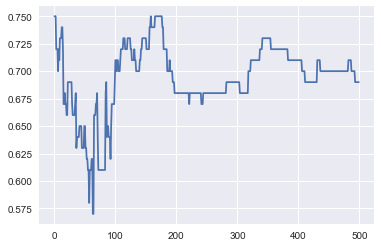

In [57]:
print("max accuracy is:")
print(max_acc)
print("best lambda is:")
print(max_reg)
plt.plot(x_plot);
plt.show()

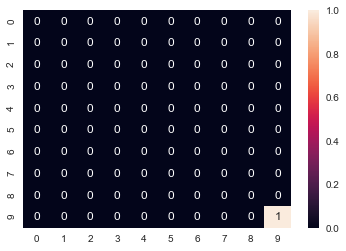

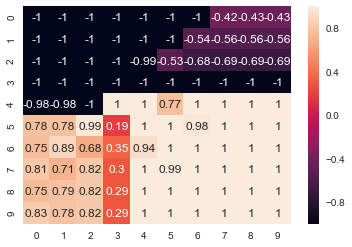

0.75


In [58]:
Rmax=1

# x=irl(num_states, num_actions, prob_matrix, opt_policy, discount_factor, Rmax, 0.09)
# reward_computed=x['x'][:num_states]
# reward_computed=np.reshape(reward_computed,(10,10))
# reward_computed=np.transpose(reward_computed)
# print(sns.heatmap(reward_1))
# print(sns.heatmap(reward_computed))

ax = sns.heatmap(reward_1, annot=True)
plt.show()

ax1 = sns.heatmap(max_reward, annot=True)
plt.show()

policy_computed = value_iteration_action(max_reward, state_space, action_set, discount_factor)
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
acc=count/100.0;
print acc


In [59]:
x_plot=[]
reward_2 = np.zeros(shape=[10,10])
reward_2[1, 4:7] = -100
reward_2[1:7, 4] = -100
reward_2[1:4, 6] = -100
reward_2[3, 6:9] = -100
reward_2[3:8, 8] = -100
reward_2[7, 6:9] = -100
reward_2[8, 6] = -100
reward_2[9,9] = 10
actual_policy=value_iteration_action(reward_2, state_space, action_set, discount_factor)
opt_policy=actual_policy
Rmax=10

In [60]:
max_acc=0
max_reg=0
max_reward=[]
for i in range(0,500):
    x=irl(num_states, num_actions, prob_matrix, opt_policy, discount_factor, Rmax, i/100.0)
    reward_computed=x['x'][:num_states]
    reward_computed=np.reshape(reward_computed,(10,10))
    reward_computed=np.transpose(reward_computed)
    policy_computed = value_iteration_action(reward_computed, state_space, action_set, discount_factor)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    acc=count/100.0;
    if(acc>max_acc):
        max_acc=acc
        max_reg=i/100.0
        max_reward=reward_computed
    x_plot.append(acc);

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.2585e+00 -1.1221e+03  2e+03  9e-02  8e+00  8e-01
 2: -3.4423e+01 -6.8431e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.3348e+02 -4.7421e+02  8e+02  3e-02  2e+00  6e-01
 4: -2.6412e+02 -5.5468e+02  9e+02  2e-02  2e+00  6e-01
 5: -3.3301e+02 -5.6734e+02  9e+02  2e-02  2e+00  6e-01
 6: -4.3662e+02 -5.6416e+02  6e+02  1e-02  9e-01  4e-01
 7: -4.5898e+02 -5.4369e+02  4e+02  7e-03  6e-01  3e-01
 8: -5.0518e+02 -5.4344e+02  2e+02  3e-03  3e-01  2e-01
 9: -5.2242e+02 -5.4582e+02  1e+02  2e-03  2e-01  1e-01
10: -5.3535e+02 -5.4714e+02  6e+01  9e-04  8e-02  6e-02
11: -5.4424e+02 -5.4961e+02  3e+01  4e-04  4e-02  3e-02
12: -5.5033e+02 -5.5154e+02  6e+00  1e-04  9e-03  6e-03
13: -5.5066e+02 -5.5159e+02  5e+00  8e-05  7e-03  5e-03
14: -5.5129e+02 -5.5174e+02  2e+00  4e-05  3e-03  2e-03
15: -5.5182e+02 -5.5188e+02  3e-01  5e-06  4e-04  3e-04
16: -5.5188e+02 -5.5190e+02  8e-02  1e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  9.7337e+00 -1.0915e+03  2e+03  9e-02  8e+00  8e-01
 2: -2.1860e+01 -6.5417e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.0568e+02 -4.2620e+02  7e+02  3e-02  2e+00  5e-01
 4: -2.3676e+02 -5.0151e+02  8e+02  2e-02  2e+00  6e-01
 5: -3.0316e+02 -5.0262e+02  7e+02  2e-02  1e+00  5e-01
 6: -3.9234e+02 -5.0413e+02  4e+02  9e-03  8e-01  3e-01
 7: -4.0538e+02 -4.8571e+02  3e+02  6e-03  6e-01  3e-01
 8: -4.6205e+02 -4.8888e+02  1e+02  2e-03  2e-01  9e-02
 9: -4.7719e+02 -4.9123e+02  6e+01  1e-03  1e-01  5e-02
10: -4.8059e+02 -4.9103e+02  4e+01  8e-04  7e-02  4e-02
11: -4.8829e+02 -4.9321e+02  2e+01  4e-04  4e-02  2e-02
12: -4.9180e+02 -4.9410e+02  1e+01  2e-04  2e-02  1e-02
13: -4.9367e+02 -4.9474e+02  5e+00  9e-05  8e-03  4e-03
14: -4.9395e+02 -4.9480e+02  4e+00  7e-05  6e-03  4e-03
15: -4.9479e+02 -4.9507e+02  1e+00  2e-05  2e-03  1e-03
16: -4.9509e+02 -4.9517e+02  3e-01  6e-06  5e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  1.5734e+01 -1.0616e+03  2e+03  9e-02  8e+00  7e-01
 2: -1.0692e+01 -6.3222e+02  1e+03  5e-02  4e+00  6e-01
 3: -8.1733e+01 -3.8380e+02  6e+02  2e-02  2e+00  5e-01
 4: -1.7849e+02 -4.4334e+02  7e+02  2e-02  2e+00  5e-01
 5: -2.5409e+02 -4.5352e+02  6e+02  2e-02  1e+00  5e-01
 6: -3.2074e+02 -4.5355e+02  5e+02  1e-02  9e-01  4e-01
 7: -3.5775e+02 -4.4663e+02  4e+02  7e-03  6e-01  3e-01
 8: -4.0938e+02 -4.4247e+02  1e+02  3e-03  2e-01  1e-01
 9: -4.2318e+02 -4.4167e+02  8e+01  1e-03  1e-01  6e-02
10: -4.3285e+02 -4.4215e+02  4e+01  7e-04  7e-02  3e-02
11: -4.3833e+02 -4.4279e+02  2e+01  4e-04  3e-02  2e-02
12: -4.3879e+02 -4.4285e+02  2e+01  3e-04  3e-02  2e-02
13: -4.4232e+02 -4.4350e+02  5e+00  9e-05  8e-03  5e-03
14: -4.4333e+02 -4.4382e+02  2e+00  4e-05  4e-03  2e-03
15: -4.4371e+02 -4.4394e+02  1e+00  2e-05  2e-03  9e-04
16: -4.4388e+02 -4.4399e+02  4e-01  9e-06  8e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  2.1303e+01 -1.0325e+03  2e+03  8e-02  7e+00  7e-01
 2: -1.0858e+00 -6.1066e+02  1e+03  5e-02  4e+00  6e-01
 3: -6.2957e+01 -3.4442e+02  6e+02  2e-02  2e+00  4e-01
 4: -1.4501e+02 -3.9810e+02  7e+02  2e-02  2e+00  5e-01
 5: -2.1292e+02 -4.1257e+02  6e+02  2e-02  1e+00  5e-01
 6: -2.7473e+02 -4.0733e+02  5e+02  1e-02  9e-01  3e-01
 7: -3.0409e+02 -4.0295e+02  4e+02  8e-03  7e-01  3e-01
 8: -3.6001e+02 -3.9728e+02  1e+02  3e-03  3e-01  1e-01
 9: -3.8206e+02 -3.9546e+02  5e+01  1e-03  9e-02  4e-02
10: -3.9093e+02 -3.9598e+02  2e+01  4e-04  4e-02  2e-02
11: -3.9409e+02 -3.9634e+02  9e+00  2e-04  2e-02  9e-03
12: -3.9551e+02 -3.9657e+02  4e+00  9e-05  7e-03  4e-03
13: -3.9664e+02 -3.9685e+02  8e-01  2e-05  1e-03  8e-04
14: -3.9683e+02 -3.9690e+02  3e-01  5e-06  5e-04  3e-04
15: -3.9690e+02 -3.9691e+02  6e-02  1e-06  1e-04  5e-05
16: -3.9691e+02 -3.9691e+02  2e-02  4e-07  3e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  2.6903e+01 -1.0192e+03  2e+03  8e-02  7e+00  7e-01
 2:  8.8516e+00 -5.9795e+02  1e+03  5e-02  4e+00  6e-01
 3: -4.3534e+01 -3.0539e+02  5e+02  2e-02  2e+00  4e-01
 4: -1.1467e+02 -3.5328e+02  6e+02  2e-02  2e+00  5e-01
 5: -1.6830e+02 -3.6796e+02  6e+02  2e-02  1e+00  4e-01
 6: -2.2318e+02 -3.5991e+02  5e+02  1e-02  9e-01  3e-01
 7: -2.7258e+02 -3.5292e+02  3e+02  6e-03  6e-01  2e-01
 8: -2.9196e+02 -3.4249e+02  2e+02  4e-03  3e-01  2e-01
 9: -3.2527e+02 -3.4486e+02  8e+01  2e-03  1e-01  6e-02
10: -3.3812e+02 -3.4528e+02  3e+01  6e-04  5e-02  2e-02
11: -3.4362e+02 -3.4573e+02  8e+00  2e-04  1e-02  8e-03
12: -3.4588e+02 -3.4623e+02  1e+00  3e-05  2e-03  1e-03
13: -3.4626e+02 -3.4633e+02  3e-01  6e-06  5e-04  3e-04
14: -3.4633e+02 -3.4634e+02  7e-02  1e-06  1e-04  7e-05
15: -3.4635e+02 -3.4635e+02  7e-03  1e-07  1e-05  7e-06
16: -3.4635e+02 -3.4635e+02  3e-04  5e-09  5e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.1802e+01 -1.0143e+03  2e+03  8e-02  7e+00  7e-01
 2:  1.7352e+01 -5.9088e+02  1e+03  5e-02  4e+00  6e-01
 3: -2.7342e+01 -2.7533e+02  4e+02  2e-02  2e+00  3e-01
 4: -9.1411e+01 -3.1287e+02  5e+02  2e-02  1e+00  4e-01
 5: -1.3026e+02 -3.2419e+02  6e+02  2e-02  1e+00  4e-01
 6: -1.7352e+02 -3.1789e+02  5e+02  1e-02  1e+00  3e-01
 7: -2.1893e+02 -3.0529e+02  3e+02  7e-03  6e-01  2e-01
 8: -2.3581e+02 -2.9936e+02  2e+02  5e-03  4e-01  2e-01
 9: -2.7137e+02 -2.9656e+02  1e+02  2e-03  2e-01  8e-02
10: -2.8412e+02 -2.9665e+02  5e+01  1e-03  8e-02  4e-02
11: -2.9299e+02 -2.9709e+02  2e+01  3e-04  3e-02  1e-02
12: -2.9576e+02 -2.9736e+02  6e+00  1e-04  1e-02  6e-03
13: -2.9687e+02 -2.9747e+02  2e+00  5e-05  4e-03  2e-03
14: -2.9731e+02 -2.9752e+02  8e-01  2e-05  1e-03  8e-04
15: -2.9753e+02 -2.9756e+02  1e-01  3e-06  2e-04  1e-04
16: -2.9757e+02 -2.9757e+02  2e-02  3e-07  3e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.6172e+01 -1.0099e+03  2e+03  8e-02  7e+00  7e-01
 2:  2.4529e+01 -5.8430e+02  1e+03  5e-02  4e+00  6e-01
 3: -1.4652e+01 -2.5175e+02  4e+02  2e-02  2e+00  3e-01
 4: -7.3923e+01 -2.7143e+02  5e+02  2e-02  1e+00  4e-01
 5: -9.9713e+01 -2.7845e+02  5e+02  1e-02  1e+00  4e-01
 6: -1.5118e+02 -2.7236e+02  4e+02  1e-02  8e-01  3e-01
 7: -1.7351e+02 -2.5725e+02  3e+02  7e-03  5e-01  2e-01
 8: -2.0515e+02 -2.5202e+02  2e+02  4e-03  3e-01  1e-01
 9: -2.2910e+02 -2.4758e+02  7e+01  1e-03  1e-01  6e-02
10: -2.4228e+02 -2.4899e+02  3e+01  5e-04  4e-02  2e-02
11: -2.4778e+02 -2.4967e+02  7e+00  2e-04  1e-02  7e-03
12: -2.4908e+02 -2.4983e+02  3e+00  6e-05  5e-03  3e-03
13: -2.4970e+02 -2.4992e+02  9e-01  2e-05  1e-03  8e-04
14: -2.4986e+02 -2.4995e+02  3e-01  7e-06  5e-04  3e-04
15: -2.4994e+02 -2.4996e+02  7e-02  2e-06  1e-04  7e-05
16: -2.4996e+02 -2.4996e+02  2e-02  4e-07  3e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.0045e+01 -1.0071e+03  2e+03  8e-02  7e+00  7e-01
 2:  3.0656e+01 -5.7886e+02  9e+02  5e-02  4e+00  6e-01
 3: -4.1826e+00 -2.3798e+02  4e+02  2e-02  1e+00  3e-01
 4: -6.0143e+01 -2.2168e+02  4e+02  1e-02  1e+00  3e-01
 5: -7.8093e+01 -2.2678e+02  4e+02  1e-02  9e-01  3e-01
 6: -1.1474e+02 -2.2819e+02  4e+02  9e-03  7e-01  3e-01
 7: -1.3132e+02 -2.1014e+02  3e+02  6e-03  5e-01  2e-01
 8: -1.6126e+02 -2.0901e+02  2e+02  4e-03  3e-01  1e-01
 9: -1.7449e+02 -2.0679e+02  1e+02  3e-03  2e-01  1e-01
10: -1.9653e+02 -2.0608e+02  4e+01  8e-04  6e-02  3e-02
11: -2.0195e+02 -2.0596e+02  1e+01  3e-04  3e-02  1e-02
12: -2.0454e+02 -2.0611e+02  6e+00  1e-04  1e-02  5e-03
13: -2.0543e+02 -2.0619e+02  3e+00  6e-05  5e-03  3e-03
14: -2.0617e+02 -2.0626e+02  4e-01  8e-06  6e-04  3e-04
15: -2.0626e+02 -2.0627e+02  3e-02  6e-07  5e-05  3e-05
16: -2.0627e+02 -2.0627e+02  5e-03  1e-07  9e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.3087e+01 -1.0051e+03  2e+03  8e-02  6e+00  7e-01
 2:  3.5303e+01 -5.7432e+02  9e+02  5e-02  4e+00  6e-01
 3:  3.6269e+00 -2.3468e+02  4e+02  2e-02  1e+00  3e-01
 4: -2.6025e+01 -1.9693e+02  3e+02  1e-02  1e+00  3e-01
 5: -6.5972e+01 -1.9496e+02  3e+02  1e-02  8e-01  2e-01
 6: -8.2078e+01 -1.9891e+02  4e+02  9e-03  7e-01  3e-01
 7: -9.2403e+01 -1.8237e+02  3e+02  7e-03  6e-01  2e-01
 8: -1.2138e+02 -1.6986e+02  2e+02  4e-03  3e-01  1e-01
 9: -1.4269e+02 -1.6946e+02  1e+02  2e-03  2e-01  8e-02
10: -1.5594e+02 -1.6953e+02  5e+01  1e-03  8e-02  4e-02
11: -1.6345e+02 -1.6941e+02  2e+01  5e-04  4e-02  2e-02
12: -1.6835e+02 -1.6999e+02  6e+00  1e-04  1e-02  6e-03
13: -1.6939e+02 -1.7011e+02  3e+00  6e-05  4e-03  3e-03
14: -1.6991e+02 -1.7018e+02  1e+00  2e-05  2e-03  1e-03
15: -1.7013e+02 -1.7021e+02  3e-01  6e-06  4e-04  3e-04
16: -1.7019e+02 -1.7021e+02  8e-02  2e-06  1e-04  

21: -1.4074e+02 -1.4074e+02  3e-04  7e-09  5e-07  3e-07
22: -1.4074e+02 -1.4074e+02  3e-06  7e-11  5e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.5839e+01 -1.0033e+03  2e+03  8e-02  6e+00  7e-01
 2:  3.9390e+01 -5.6994e+02  9e+02  5e-02  4e+00  6e-01
 3:  9.6104e+00 -2.2912e+02  4e+02  2e-02  1e+00  3e-01
 4: -8.7404e+00 -1.7742e+02  3e+02  1e-02  1e+00  2e-01
 5: -4.9091e+01 -1.5870e+02  3e+02  9e-03  7e-01  2e-01
 6: -5.0720e+01 -1.5774e+02  3e+02  9e-03  6e-01  2e-01
 7: -7.5967e+01 -1.5473e+02  2e+02  6e-03  5e-01  2e-01
 8: -8.5678e+01 -1.4546e+02  2e+02  5e-03  4e-01  1e-01
 9: -1.0070e+02 -1.3574e+02  1e+02  3e-03  2e-01  1e-01
10: -1.1749e+02 -1.3501e+02  6e+01  1e-03  1e-01  5e-02
11: -1.2131e+02 -1.3458e+02  5e+01  1e-03  8e-02  4e-02
12: -1.3113e+02 -1.3522e+02  1e+01  3e-04  2e-02  1e-02
13: -1.3319e+02 -1.3554e+02  8e+00  2e-04  1e-02  8e-03
14: -1.3449e+02 -1.3568e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.7990e+01 -1.0019e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.2510e+01 -5.6628e+02  9e+02  5e-02  4e+00  6e-01
 3:  1.3674e+01 -2.2284e+02  4e+02  2e-02  1e+00  2e-01
 4: -1.0917e-01 -1.6008e+02  3e+02  1e-02  9e-01  2e-01
 5: -3.4603e+01 -1.2360e+02  2e+02  7e-03  5e-01  2e-01
 6: -4.1633e+01 -1.2293e+02  2e+02  7e-03  5e-01  2e-01
 7: -5.2834e+01 -1.2539e+02  2e+02  6e-03  4e-01  2e-01
 8: -7.4278e+01 -1.1770e+02  1e+02  3e-03  3e-01  1e-01
 9: -8.9750e+01 -1.1087e+02  7e+01  2e-03  1e-01  5e-02
10: -9.5460e+01 -1.0773e+02  4e+01  1e-03  7e-02  4e-02
11: -1.0208e+02 -1.0697e+02  2e+01  4e-04  3e-02  2e-02
12: -1.0485e+02 -1.0721e+02  8e+00  2e-04  1e-02  8e-03
13: -1.0663e+02 -1.0736e+02  2e+00  6e-05  4e-03  2e-03
14: -1.0720e+02 -1.0738e+02  6e-01  1e-05  1e-03  6e-04
15: -1.0731e+02 -1.0739e+02  3e-01  6e-06  5e-04  3e-04
16: -1.0737e+02 -1.0739e+02  6e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  5.0277e+01 -1.0006e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.6183e+01 -5.6513e+02  9e+02  5e-02  3e+00  6e-01
 3:  1.8078e+01 -2.1469e+02  3e+02  2e-02  1e+00  2e-01
 4:  6.1208e+00 -1.3620e+02  2e+02  1e-02  8e-01  2e-01
 5: -1.4599e+01 -9.7972e+01  2e+02  7e-03  5e-01  1e-01
 6: -3.0475e+01 -1.0202e+02  2e+02  6e-03  4e-01  1e-01
 7: -3.2824e+01 -9.7997e+01  2e+02  5e-03  4e-01  1e-01
 8: -4.5638e+01 -9.0392e+01  1e+02  4e-03  3e-01  1e-01
 9: -5.7229e+01 -8.5536e+01  8e+01  2e-03  2e-01  7e-02
10: -6.5227e+01 -8.1481e+01  5e+01  1e-03  9e-02  4e-02
11: -7.2137e+01 -7.9212e+01  2e+01  6e-04  4e-02  2e-02
12: -7.4730e+01 -7.8636e+01  1e+01  3e-04  2e-02  1e-02
13: -7.7076e+01 -7.8285e+01  4e+00  1e-04  7e-03  4e-03
14: -7.7859e+01 -7.8225e+01  1e+00  3e-05  2e-03  1e-03
15: -7.8086e+01 -7.8209e+01  4e-01  1e-05  7e-04  4e-04
16: -7.8164e+01 -7.8204e+01  1e-01  3e-06  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  5.2348e+01 -9.9944e+02  2e+03  8e-02  6e+00  7e-01
 2:  4.9890e+01 -5.6649e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.1771e+01 -2.0555e+02  3e+02  2e-02  1e+00  2e-01
 4:  9.9448e+00 -1.0979e+02  2e+02  1e-02  6e-01  1e-01
 5: -2.0785e+00 -7.6933e+01  1e+02  6e-03  4e-01  1e-01
 6: -1.6183e+01 -7.5895e+01  1e+02  5e-03  3e-01  1e-01
 7: -1.5532e+01 -7.0876e+01  1e+02  4e-03  3e-01  1e-01
 8: -1.9949e+01 -6.7014e+01  1e+02  4e-03  3e-01  1e-01
 9: -3.3838e+01 -6.0287e+01  7e+01  2e-03  1e-01  6e-02
10: -4.1156e+01 -5.5281e+01  4e+01  1e-03  8e-02  3e-02
11: -4.8402e+01 -5.2905e+01  1e+01  4e-04  2e-02  1e-02
12: -4.9715e+01 -5.2462e+01  8e+00  2e-04  1e-02  7e-03
13: -5.1418e+01 -5.2149e+01  2e+00  6e-05  4e-03  2e-03
14: -5.1813e+01 -5.2076e+01  8e-01  2e-05  1e-03  7e-04
15: -5.1966e+01 -5.2056e+01  3e-01  7e-06  5e-04  3e-04
16: -5.2026e+01 -5.2048e+01  7e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.4224e+01 -9.9845e+02  2e+03  8e-02  6e+00  7e-01
 2:  5.3313e+01 -5.6763e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.5022e+01 -1.9529e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.2584e+01 -8.2311e+01  1e+02  8e-03  5e-01  1e-01
 5:  5.8398e+00 -5.6434e+01  1e+02  5e-03  3e-01  9e-02
 6: -7.2925e+00 -4.0085e+01  7e+01  3e-03  2e-01  7e-02
 7: -7.3942e+00 -3.9044e+01  7e+01  3e-03  2e-01  7e-02
 8: -1.1417e+01 -3.7880e+01  6e+01  2e-03  1e-01  6e-02
 9: -1.4070e+01 -3.5530e+01  5e+01  2e-03  1e-01  5e-02
10: -1.9534e+01 -3.3707e+01  4e+01  1e-03  7e-02  3e-02
11: -2.0227e+01 -3.2765e+01  3e+01  1e-03  7e-02  3e-02
12: -2.5279e+01 -3.0873e+01  1e+01  4e-04  3e-02  1e-02
13: -2.6242e+01 -3.0289e+01  1e+01  3e-04  2e-02  1e-02
14: -2.6710e+01 -3.0118e+01  9e+00  3e-04  2e-02  9e-03
15: -2.8878e+01 -2.9625e+01  2e+00  6e-05  4e-03  2e-03
16: -2.9255e+01 -2.9518e+01  7e-01  2e-05  1e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.5921e+01 -9.9762e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.6485e+01 -5.6858e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.8243e+01 -1.8417e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.3722e+01 -5.3858e+01  1e+02  5e-03  3e-01  9e-02
 5:  9.7103e+00 -3.4096e+01  7e+01  4e-03  2e-01  7e-02
 6:  2.6833e+00 -1.7745e+01  4e+01  2e-03  1e-01  4e-02
 7: -1.3832e+00 -1.7106e+01  4e+01  1e-03  8e-02  3e-02
 8: -1.1988e+00 -1.6133e+01  3e+01  1e-03  8e-02  3e-02
 9: -3.3804e+00 -1.4510e+01  2e+01  9e-04  6e-02  2e-02
10: -3.9604e+00 -1.3928e+01  2e+01  8e-04  5e-02  2e-02
11: -4.2135e+00 -1.2737e+01  2e+01  7e-04  4e-02  2e-02
12: -5.4788e+00 -1.2030e+01  2e+01  5e-04  3e-02  1e-02
13: -6.0321e+00 -1.1512e+01  1e+01  4e-04  3e-02  1e-02
14: -7.7333e+00 -1.0890e+01  8e+00  3e-04  2e-02  7e-03
15: -7.7412e+00 -1.0882e+01  8e+00  3e-04  2e-02  7e-03
16: -8.8300e+00 -1.0346e+01  4e+00  1e-04  8e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7664e+01 -9.9683e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.9837e+01 -5.6942e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.1414e+01 -1.7015e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.5859e+01 -4.4944e+01  9e+01  5e-03  3e-01  8e-02
 5:  9.6009e+00 -1.9771e+01  4e+01  2e-03  1e-01  4e-02
 6:  3.1496e+00 -3.0500e+00  8e+00  5e-04  3e-02  8e-03
 7:  6.8828e-01 -3.5928e-01  1e+00  8e-05  5e-03  1e-03
 8:  1.2185e-01 -4.0495e-02  2e-01  1e-05  8e-04  2e-04
 9:  1.2873e-03 -4.2228e-04  2e-03  1e-07  8e-06  2e-06
10:  1.2872e-05 -4.2223e-06  2e-05  1e-09  8e-08  2e-08
11:  1.2872e-07 -4.2223e-08  2e-07  1e-11  8e-10  2e-10
12:  1.2872e-09 -4.2223e-10  2e-09  1e-13  1e-11  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7868e+01 -9.9675e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.0237e+01 -5.6951e+02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.9930e+01 -9.9594e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.4387e+01 -5.7028e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.6058e+01 -1.5763e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.7469e+01 -4.0012e+01  8e+01  5e-03  3e-01  7e-02
 5:  5.5918e+00 -6.9679e+00  2e+01  1e-03  6e-02  1e-02
 6:  5.7220e-01 -1.2773e-01  8e-01  6e-05  3e-03  8e-04
 7:  5.9178e-03 -1.3206e-03  8e-03  6e-07  3e-05  8e-06
 8:  5.9171e-05 -1.3204e-05  8e-05  6e-09  3e-07  8e-08
 9:  5.9171e-07 -1.3204e-07  8e-07  6e-11  3e-09  8e-10
10:  5.9171e-09 -1.3204e-09  8e-09  6e-13  3e-11  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.0101e+01 -9.9587e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.4743e+01 -5.7032e+02  1e+03  5e-02  3e+00  6e-01
 3:  3.6478e+01 -1.5757e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.7486e+01 -3.9553e+01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.1832e+01 -9.9532e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.8447e+01 -5.7067e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.0752e+01 -1.5668e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.6454e+01 -3.1054e+01  6e+01  4e-03  2e-01  5e-02
 5:  3.1603e+00 -2.7043e+00  7e+00  5e-04  3e-02  6e-03
 6:  6.0179e-02 -2.8035e-02  1e-01  7e-06  4e-04  9e-05
 7:  6.0145e-04 -2.8019e-04  1e-03  7e-08  4e-06  9e-07
 8:  6.0144e-06 -2.8018e-06  1e-05  7e-10  4e-08  9e-09
 9:  6.0144e-08 -2.8018e-08  1e-07  7e-12  4e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.1976e+01 -9.9528e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.8766e+01 -5.7068e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.1112e+01 -1.5658e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.6275e+01 -3.0106e+01  6e+01  4e-03  2e-01  5e-02
 5:  2.9889e+00 -2.4963e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.3544e+01 -9.9490e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.2380e+01 -5.7061e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.5106e+01 -1.5503e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.5656e+01 -2.3121e+01  5e+01  3e-03  2e-01  4e-02
 5:  1.6280e+00 -9.6747e-01  3e+00  2e-04  1e-02  2e-03
 6:  1.6925e-02 -9.8247e-03  3e-02  2e-06  1e-04  3e-05
 7:  1.6923e-04 -9.8231e-05  3e-04  2e-08  1e-06  3e-07
 8:  1.6923e-06 -9.8231e-07  3e-06  2e-10  1e-08  3e-09
 9:  1.6923e-08 -9.8231e-09  3e-08  2e-12  1e-10  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.3662e+01 -9.9488e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.2664e+01 -5.7058e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.5414e+01 -1.5488e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.5619e+01 -2.2655e+01  5e+01  3e-03  2e-01  4e-02
 5:  1.5463e+00 -8.9882e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.5045e+01 -9.9469e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.6159e+01 -5.7003e+02  1e+03  5e-02  2e+00  6e-01
 3:  4.9121e+01 -1.5269e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.4758e+01 -1.6948e+01  4e+01  3e-03  1e-01  3e-02
 5:  7.6077e-01 -3.6878e-01  1e+00  9e-05  4e-03  1e-03
 6:  7.6082e-03 -3.6874e-03  1e-02  9e-07  4e-05  1e-05
 7:  7.6077e-05 -3.6872e-05  1e-04  9e-09  4e-07  1e-07
 8:  7.6077e-07 -3.6872e-07  1e-06  9e-11  4e-09  1e-09
 9:  7.6077e-09 -3.6872e-09  1e-08  9e-13  4e-11  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.5140e+01 -9.9468e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.6412e+01 -5.6997e+02  1e+03  5e-02  2e+00  6e-01
 3:  4.9385e+01 -1.5251e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.4668e+01 -1.6540e+01  4e+01  2e-03  1e-01  3e-02
 5:  7.1930e-01 -3.4378e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6245e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9539e+01 -5.6895e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2580e+01 -1.4993e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3291e+01 -1.1720e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.5201e-01 -1.5349e-01  6e-01  4e-05  2e-03  5e-04
 6:  3.5158e-03 -1.5331e-03  6e-03  4e-07  2e-05  5e-06
 7:  3.5158e-05 -1.5331e-05  6e-05  4e-09  2e-07  5e-08
 8:  3.5158e-07 -1.5331e-07  6e-07  4e-11  2e-09  5e-10
 9:  3.5158e-09 -1.5331e-09  6e-09  4e-13  2e-11  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6321e+01 -9.9466e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9767e+01 -5.6886e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2809e+01 -1.4972e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3173e+01 -1.1387e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.3701e-01 -1.4823e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7195e+01 -9.9475e+02  2e+03  8e-02  4e+00  7e-01
 2:  8.2584e+01 -5.6741e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.5588e+01 -1.4685e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.2417e+01 -1.0257e+01  3e+01  2e-03  8e-02  2e-02
 5:  2.4601e-01 -1.2262e-01  4e-01  3e-05  1e-03  4e-04
 6:  2.4580e-03 -1.2252e-03  4e-03  3e-07  1e-05  4e-06
 7:  2.4580e-05 -1.2252e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.4580e-07 -1.2252e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.4580e-09 -1.2252e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7254e+01 -9.9477e+02  2e+03  8e-02  4e+00  7e-01
 2:  8.2790e+01 -5.6729e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.5788e+01 -1.4662e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.2372e+01 -1.0239e+01  3e+01  2e-03  8e-02  2e-02
 5:  2.4176e-01 -1.2183e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7933e+01 -9.9495e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.5344e+01 -5.6544e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.8224e+01 -1.4353e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.1685e+01 -9.8638e+00  3e+01  2e-03  7e-02  2e-02
 5:  1.9286e-01 -1.1171e-01  4e-01  2e-05  1e-03  3e-04
 6:  1.9273e-03 -1.1163e-03  4e-03  2e-07  1e-05  3e-06
 7:  1.9272e-05 -1.1163e-05  4e-05  2e-09  1e-07  3e-08
 8:  1.9272e-07 -1.1163e-07  4e-07  2e-11  1e-09  3e-10
 9:  1.9272e-09 -1.1163e-09  4e-09  2e-13  1e-11  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7978e+01 -9.9497e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.5531e+01 -5.6528e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.8400e+01 -1.4328e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.1626e+01 -9.8259e+00  3e+01  2e-03  7e-02  2e-02
 5:  1.8958e-01 -1.1093e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8492e+01 -9.9522e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.7861e+01 -5.6306e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.0545e+01 -1.4000e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.0801e+01 -9.2592e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.5291e-01 -1.0103e-01  3e-01  2e-05  8e-04  3e-04
 6:  1.5283e-03 -1.0098e-03  3e-03  2e-07  8e-06  3e-06
 7:  1.5283e-05 -1.0098e-05  3e-05  2e-09  8e-08  3e-08
 8:  1.5283e-07 -1.0098e-07  3e-07  2e-11  8e-10  3e-10
 9:  1.5283e-09 -1.0098e-09  3e-09  2e-13  8e-12  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8526e+01 -9.9524e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.8032e+01 -5.6288e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.0700e+01 -1.3974e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.0734e+01 -9.2111e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.5051e-01 -1.0028e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8900e+01 -9.9553e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.0170e+01 -5.6032e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.2596e+01 -1.3629e+02  3e+02  2e-02  6e-01  2e-01
 4:  9.8495e+00 -8.5495e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.2385e-01 -9.0774e-02  3e-01  2e-05  6e-04  2e-04
 6:  1.2380e-03 -9.0738e-04  3e-03  2e-07  6e-06  2e-06
 7:  1.2380e-05 -9.0737e-06  3e-05  2e-09  6e-08  2e-08
 8:  1.2380e-07 -9.0737e-08  3e-07  2e-11  6e-10  2e-10
 9:  1.2380e-09 -9.0737e-10  3e-09  2e-13  6e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8924e+01 -9.9556e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.0328e+01 -5.6011e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.2733e+01 -1.3602e+02  3e+02  2e-02  6e-01  2e-01
 4:  9.7806e+00 -8.4964e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.2211e-01 -9.0060e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9181e+01 -9.9587e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.2300e+01 -5.5724e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.4410e+01 -1.3243e+02  3e+02  2e-02  5e-01  3e-01
 4:  8.8857e+00 -7.7871e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.0258e-01 -8.1018e-02  2e-01  1e-05  5e-04  2e-04
 6:  1.0255e-03 -8.0993e-04  2e-03  1e-07  5e-06  2e-06
 7:  1.0255e-05 -8.0993e-06  2e-05  1e-09  5e-08  2e-08
 8:  1.0255e-07 -8.0993e-08  2e-07  1e-11  5e-10  2e-10
 9:  1.0255e-09 -8.0993e-10  2e-09  1e-13  5e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9197e+01 -9.9589e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.2446e+01 -5.5701e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.4531e+01 -1.3214e+02  3e+02  2e-02  5e-01  3e-01
 4:  8.8174e+00 -7.7313e+00  2e+01  1e-03  4e-02  2e-02
 5:  1.0129e-01 -8.0339e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9354e+01 -9.9621e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.4275e+01 -5.5386e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.6013e+01 -1.2840e+02  3e+02  2e-02  5e-01  3e-01
 4:  7.8207e+00 -6.4421e+00  2e+01  1e-03  4e-02  2e-02
 5:  8.4194e-02 -6.6090e-02  2e-01  1e-05  4e-04  2e-04
 6:  8.4174e-04 -6.6074e-04  2e-03  1e-07  4e-06  2e-06
 7:  8.4174e-06 -6.6074e-06  2e-05  1e-09  4e-08  2e-08
 8:  8.4174e-08 -6.6074e-08  2e-07  1e-11  4e-10  2e-10
 9:  8.4174e-10 -6.6074e-10  2e-09  1e-13  4e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9362e+01 -9.9623e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.4410e+01 -5.5361e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.6120e+01 -1.2811e+02  3e+02  2e-02  5e-01  3e-01
 4:  7.7315e+00 -6.2875e+00  2e+01  1e-03  4e-02  2e-02
 5:  8.2888e-02 -6.4508e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9435e+01 -9.9654e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.6114e+01 -5.5021e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.7426e+01 -1.2422e+02  3e+02  2e-02  5e-01  3e-01
 4:  6.6355e+00 -4.5220e+00  1e+01  9e-04  3e-02  1e-02
 5:  6.8669e-02 -4.6385e-02  1e-01  9e-06  3e-04  1e-04
 6:  6.8657e-04 -4.6376e-04  1e-03  9e-08  3e-06  1e-06
 7:  6.8656e-06 -4.6376e-06  1e-05  9e-10  3e-08  1e-08
 8:  6.8656e-08 -4.6376e-08  1e-07  9e-12  3e-10  1e-10
 9:  6.8656e-10 -4.6376e-10  1e-09  9e-14  3e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9438e+01 -9.9656e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.6240e+01 -5.4994e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.7521e+01 -1.2392e+02  3e+02  2e-02  5e-01  3e-01
 4:  6.5865e+00 -4.4631e+00  1e+01  9e-04  3e-02  1e-02
 5:  6.8086e-02 -4.5772e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9440e+01 -9.9686e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.7834e+01 -5.4631e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.8669e+01 -1.1989e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.9509e+00 -3.7396e+00  1e+01  8e-04  2e-02  1e-02
 5:  6.0801e-02 -3.8205e-02  1e-01  8e-06  2e-04  1e-04
 6:  6.0792e-04 -3.8199e-04  1e-03  8e-08  2e-06  1e-06
 7:  6.0791e-06 -3.8199e-06  1e-05  8e-10  2e-08  1e-08
 8:  6.0791e-08 -3.8199e-08  1e-07  8e-12  2e-10  1e-10
 9:  6.0791e-10 -3.8199e-10  1e-09  8e-14  2e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9437e+01 -9.9688e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.7953e+01 -5.4603e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.8757e+01 -1.1965e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.9064e+00 -3.6908e+00  1e+01  8e-04  2e-02  1e-02
 5:  6.0305e-02 -3.7694e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9378e+01 -9.9715e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9449e+01 -5.4221e+02  1e+03  5e-02  1e+00  6e-01
 3:  6.9976e+01 -1.1857e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.4266e+00 -3.1580e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.5025e-02 -3.2119e-02  1e-01  7e-06  2e-04  1e-04
 6:  5.5017e-04 -3.2114e-04  1e-03  7e-08  2e-06  1e-06
 7:  5.5017e-06 -3.2114e-06  1e-05  7e-10  2e-08  1e-08
 8:  5.5017e-08 -3.2114e-08  1e-07  7e-12  2e-10  1e-10
 9:  5.5017e-10 -3.2114e-10  1e-09  7e-14  2e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9372e+01 -9.9717e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9560e+01 -5.4191e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.0063e+01 -1.1847e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.3887e+00 -3.1177e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.4614e-02 -3.1698e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9262e+01 -9.9741e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0097e+02 -5.3792e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.1130e+01 -1.1683e+02  3e+02  2e-02  4e-01  3e-01
 4:  4.9188e+00 -2.6613e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.9608e-02 -2.6946e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.9602e-04 -2.6943e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.9602e-06 -2.6943e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.9602e-08 -2.6943e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9252e+01 -9.9742e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0108e+02 -5.3761e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.1207e+01 -1.1669e+02  3e+02  2e-02  4e-01  3e-01
 4:  4.9100e+00 -2.6750e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.9522e-02 -2.7084e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.9516e-04 -2.7081e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9072e+01 -9.9766e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0261e+02 -5.3284e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.2270e+01 -1.1421e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.7424e+00 -2.8183e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.7841e-02 -2.8503e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.7836e-04 -2.8500e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.7836e-06 -2.8500e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.7836e-08 -2.8500e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9059e+01 -9.9767e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0270e+02 -5.3252e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.2336e+01 -1.1402e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.7291e+00 -2.8240e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.7705e-02 -2.8558e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.7701e-04 -2.8555e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.8849e+01 -9.9784e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0405e+02 -5.2792e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3184e+01 -1.1119e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.5200e+00 -2.8602e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.5553e-02 -2.8875e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.5549e-04 -2.8873e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.5549e-06 -2.8873e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.5549e-08 -2.8873e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.8833e+01 -9.9785e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0414e+02 -5.2759e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3240e+01 -1.1097e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.5036e+00 -2.8599e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.5383e-02 -2.8869e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.5379e-04 -2.8866e-04 

 6:  4.2829e-04 -2.8420e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.2829e-06 -2.8420e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.2829e-08 -2.8420e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8571e+01 -9.9798e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0551e+02 -5.2255e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4011e+01 -1.0746e+02  3e+02  1e-02  3e-01  3e-01
 4:  4.2384e+00 -2.8163e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.2639e-02 -2.8368e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.2636e-04 -2.8366e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.2636e-06 -2.8365e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.2636e-08 -2.8365e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8552e+01 -9.9799e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0559e+02 -5.2222e+02  1e+03  5e-02  1e+00  6e-01
 3: 

 4:  3.9663e+00 -2.7208e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.9833e-02 -2.7350e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.9830e-04 -2.7348e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.9830e-06 -2.7348e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.9830e-08 -2.7348e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8279e+01 -9.9806e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0680e+02 -5.1743e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4663e+01 -1.0351e+02  3e+02  1e-02  3e-01  3e-01
 4:  3.9493e+00 -2.7089e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.9656e-02 -2.7227e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.9654e-04 -2.7225e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.9654e-06 -2.7225e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.9654e-08 -2.7225e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7963e+01 -9.9808e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0802e+02 -5.1224e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.5209e+01 -9.9166e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.8164e+00 -2.3888e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.8245e-02 -2.3967e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.8242e-04 -2.3965e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.8242e-06 -2.3965e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.8242e-08 -2.3965e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7942e+01 -9.9808e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0810e+02 -5.1189e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.5242e+01 -9.8863e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.8114e+00 -2.3639e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.8190e-02 -2.3715e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.8187e-04 -2.3713e-04 

 1:  6.7628e+01 -9.9805e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0868e+02 -5.1294e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4968e+01 -9.7383e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.7558e+00 -2.2525e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.7594e-02 -2.2574e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.7592e-04 -2.2572e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.7592e-06 -2.2572e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.7592e-08 -2.2572e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7605e+01 -9.9804e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0872e+02 -5.1304e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4940e+01 -9.7274e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.7722e+00 -2.2724e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.7758e-02 -2.2773e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.7756e-04 -2.2772e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.7756e-06 -2.2772e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.7756e-08 -2.2772e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7277e+01 -9.9796e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0921e+02 -5.1422e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4462e+01 -9.5548e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.9828e+00 -2.5187e+00  8e+00  5e-04  1e-02  1e-02
 5:  3.9858e-02 -2.5232e-02  8e-02  5e-06  1e-04  1e-04
 6:  3.9856e-04 -2.5230e-04  8e-04  5e-08  1e-06  1e-06
 7:  3.9856e-06 -2.5230e-06  8e-06  5e-10  1e-08  1e-08
 8:  3.9856e-08 -2.5230e-08  8e-08  5e-12  1e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7253e+01 -9.9795e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0924e+02 -5.1429e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4423e+01 -9.5411e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.9965e+00 -2.5341e+00  8e+00  5e-04  1e-02  1e-02
 5:  3.9994e-02 -2.5385e-02  8e-02  5e-06  1e-04  1e-04
 6:  3.9992e-04 -2.5383e-04 

 2:  1.0968e+02 -5.1526e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4030e+01 -9.5986e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.6607e+00 -2.4462e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.6598e-02 -2.4475e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.6596e-04 -2.4473e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.6596e-06 -2.4473e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.6596e-08 -2.4473e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6889e+01 -9.9780e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0971e+02 -5.1532e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4012e+01 -9.6189e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.6095e+00 -2.4240e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.6083e-02 -2.4250e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.6081e-04 -2.4249e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.6081e-06 -2.4249e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.6081e-08 -2.4249e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6541e+01 -9.9761e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1010e+02 -5.1609e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3691e+01 -9.8524e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.0547e+00 -2.1866e+00  7e+00  4e-04  8e-03  8e-03
 5:  3.0511e-02 -2.1852e-02  7e-02  4e-06  8e-05  8e-05
 6:  3.0509e-04 -2.1851e-04  7e-04  4e-08  8e-07  8e-07
 7:  3.0509e-06 -2.1851e-06  7e-06  4e-10  8e-09  8e-09
 8:  3.0509e-08 -2.1851e-08  7e-08  4e-12  8e-11  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6516e+01 -9.9759e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1013e+02 -5.1614e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3663e+01 -9.8658e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.0237e+00 -2.1734e+00  7e+00  4e-04  8e-03  7e-03
 5:  3.0200e-02 -2.1719e-02  7e-02  4e-06  8e-05  7e-05
 6:  3.0198e-04 -2.1718e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6161e+01 -9.9735e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1047e+02 -5.1673e+02  1e+03  5e-02  9e-01  6e-01
 3:  7.3202e+01 -1.0010e+02  2e+02  1e-02  3e-01  3e-01
 4:  2.6948e+00 -2.0526e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6904e-02 -2.0500e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6903e-04 -2.0500e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6903e-06 -2.0500e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6903e-08 -2.0500e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6135e+01 -9.9733e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1049e+02 -5.1677e+02  1e+03  5e-02  9e-01  6e-01
 3:  7.3165e+01 -1.0018e+02  2e+02  1e-02  3e-01  3e-01
 4:  2.6964e+00 -2.0631e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6920e-02 -2.0605e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6919e-04 -2.0604e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5750e+01 -9.9701e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1081e+02 -5.1723e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.2544e+01 -1.0090e+02  3e+02  1e-02  3e-01  3e-01
 4:  2.6919e+00 -2.1838e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6870e-02 -2.1803e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6869e-04 -2.1803e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6869e-06 -2.1803e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6869e-08 -2.1803e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5724e+01 -9.9699e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1083e+02 -5.1726e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.2498e+01 -1.0093e+02  3e+02  1e-02  3e-01  3e-01
 4:  2.6899e+00 -2.1895e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6849e-02 -2.1860e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6848e-04 -2.1859e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5335e+01 -9.9661e+02  2e+03  8e-02  1e+00  6e-01
 2:  1.1111e+02 -5.1755e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.1766e+01 -1.0096e+02  2e+02  1e-02  2e-01  3e-01
 4:  2.6369e+00 -2.2430e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6320e-02 -2.2392e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6319e-04 -2.2391e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6319e-06 -2.2391e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6319e-08 -2.2391e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5309e+01 -9.9659e+02  2e+03  8e-02  1e+00  6e-01
 2:  1.1113e+02 -5.1756e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.1714e+01 -1.0094e+02  2e+02  1e-02  2e-01  3e-01
 4:  2.6320e+00 -2.2445e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6272e-02 -2.2407e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6271e-04 -2.2407e-04 

max accuracy is:
0.88
best lambda is:
1.69


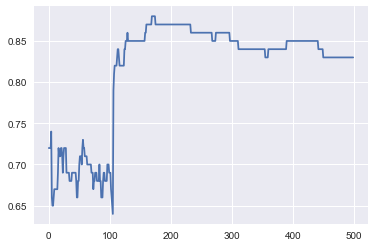

In [61]:
print("max accuracy is:")
print(max_acc)
print("best lambda is:")
print(max_reg)
plt.plot(x_plot);
plt.show()

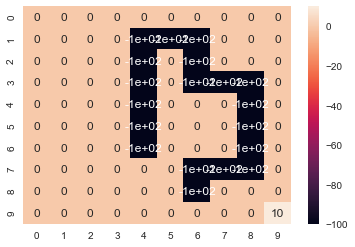

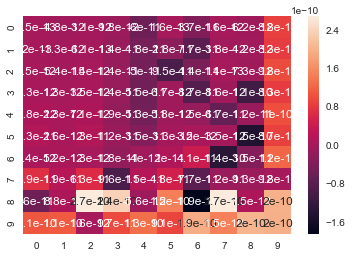

0.88


In [62]:
ax = sns.heatmap(reward_2, annot=True)
plt.show()

ax1 = sns.heatmap(max_reward, annot=True)
plt.show()

policy_computed = value_iteration_action(max_reward, state_space, action_set, discount_factor)
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
acc=count/100.0;
print acc

